# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, train_test_split
from sklearn.ensemble import VotingClassifier
import pickle
import lightgbm as lgb
import h5py
from io import BytesIO
import joblib
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch import optim
from torchvision import datasets, transforms, models
from PIL import Image
import gc

# Define Custom Metric: Partial Area Under Curve (PAUC)

In [2]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

# Exploratory data analysis (EDA)

In [3]:
Root_DIR = "/kaggle/input/isic-2024-challenge"
train_csv = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
train_hdf = '/kaggle/input/isic-2024-challenge/train-image.hdf5'

In [4]:
df = pd.read_csv(train_csv)
print(df.head())
print(df.describe())
print(df.info())

/tmp/ipykernel_18/1222220479.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_csv)


        isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3D: white  20.244422  ...   
1                    1.10  TBP tile: close-up     3D: white  31.712570  ...   
2                    3.40  TBP tile: close-up        3D: XP  22.575830  ...   
3                    3.22  TBP tile: close-up        3D: XP  14.242329  ...   
4                    2.73  TBP tile: close-up     3D: white  24.725520  ...   

    lesion_id  iddx_full  iddx_1  iddx_2  iddx_3  iddx_4  iddx

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


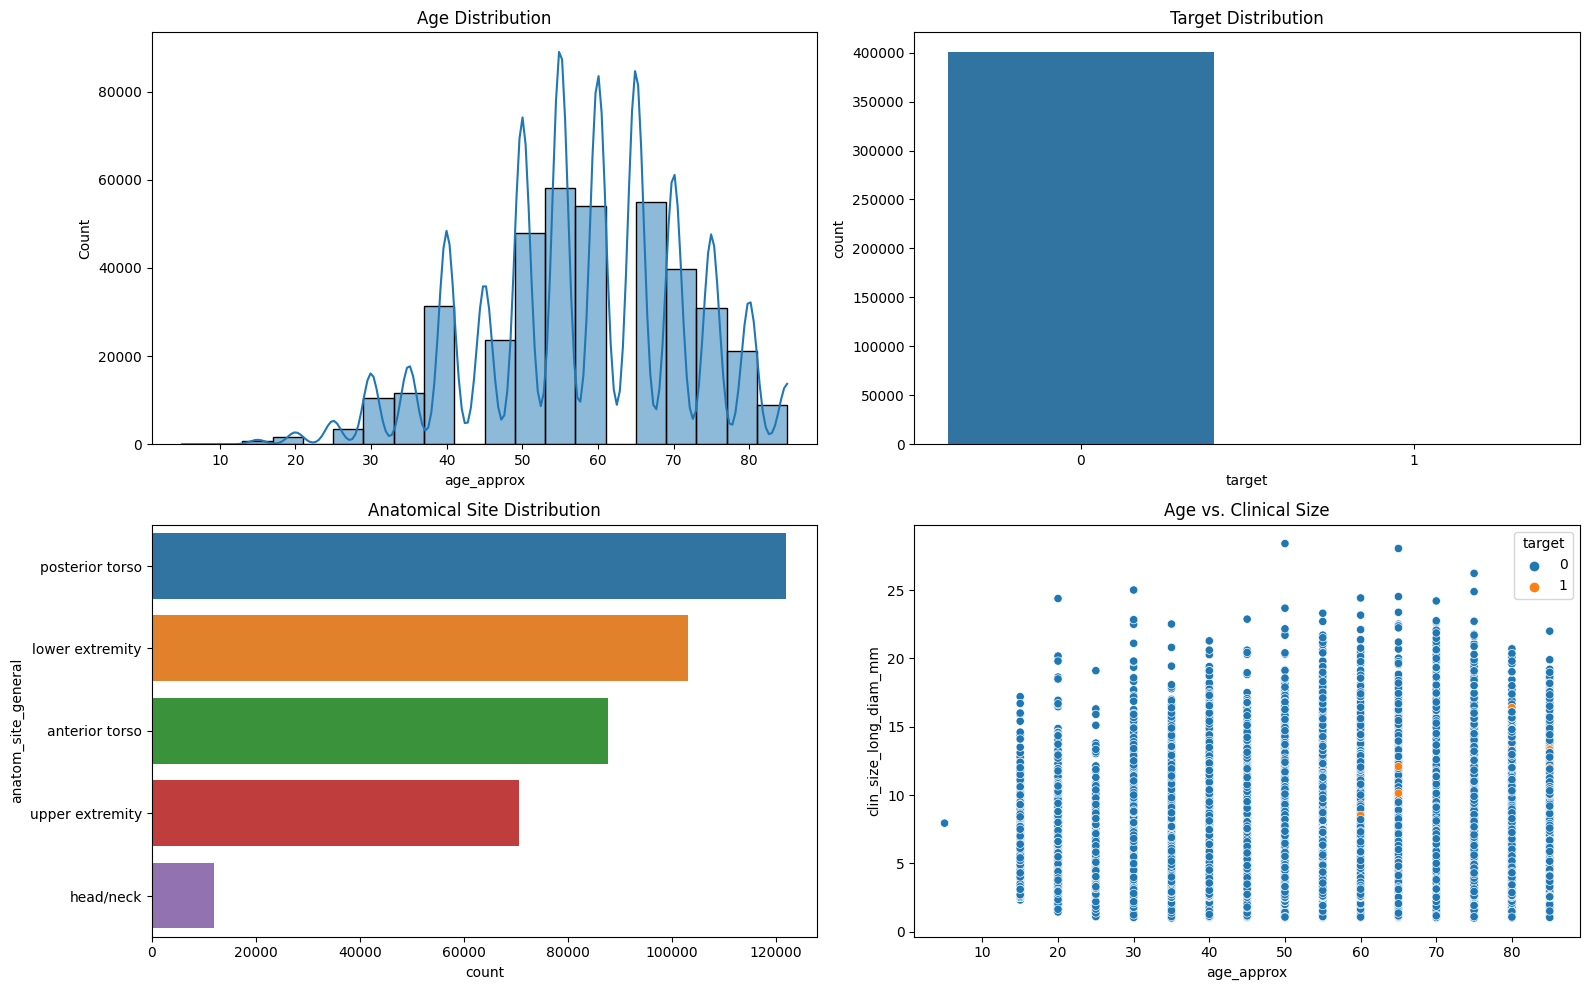

In [5]:
df.describe(include='all')

# Plot distributions and relationships
plt.figure(figsize=(16, 10))

# Age distribution
plt.subplot(2, 2, 1)
sns.histplot(df['age_approx'].dropna(), bins=20, kde=True)
plt.title('Age Distribution')

# Target distribution
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='target')
plt.title('Target Distribution')

# Anatomical site distribution
plt.subplot(2, 2, 3)
sns.countplot(data=df, y='anatom_site_general', order=df['anatom_site_general'].value_counts().index)
plt.title('Anatomical Site Distribution')

# Age vs. Clinical Size
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='age_approx', y='clin_size_long_diam_mm', hue='target')
plt.title('Age vs. Clinical Size')

plt.tight_layout()
plt.show()

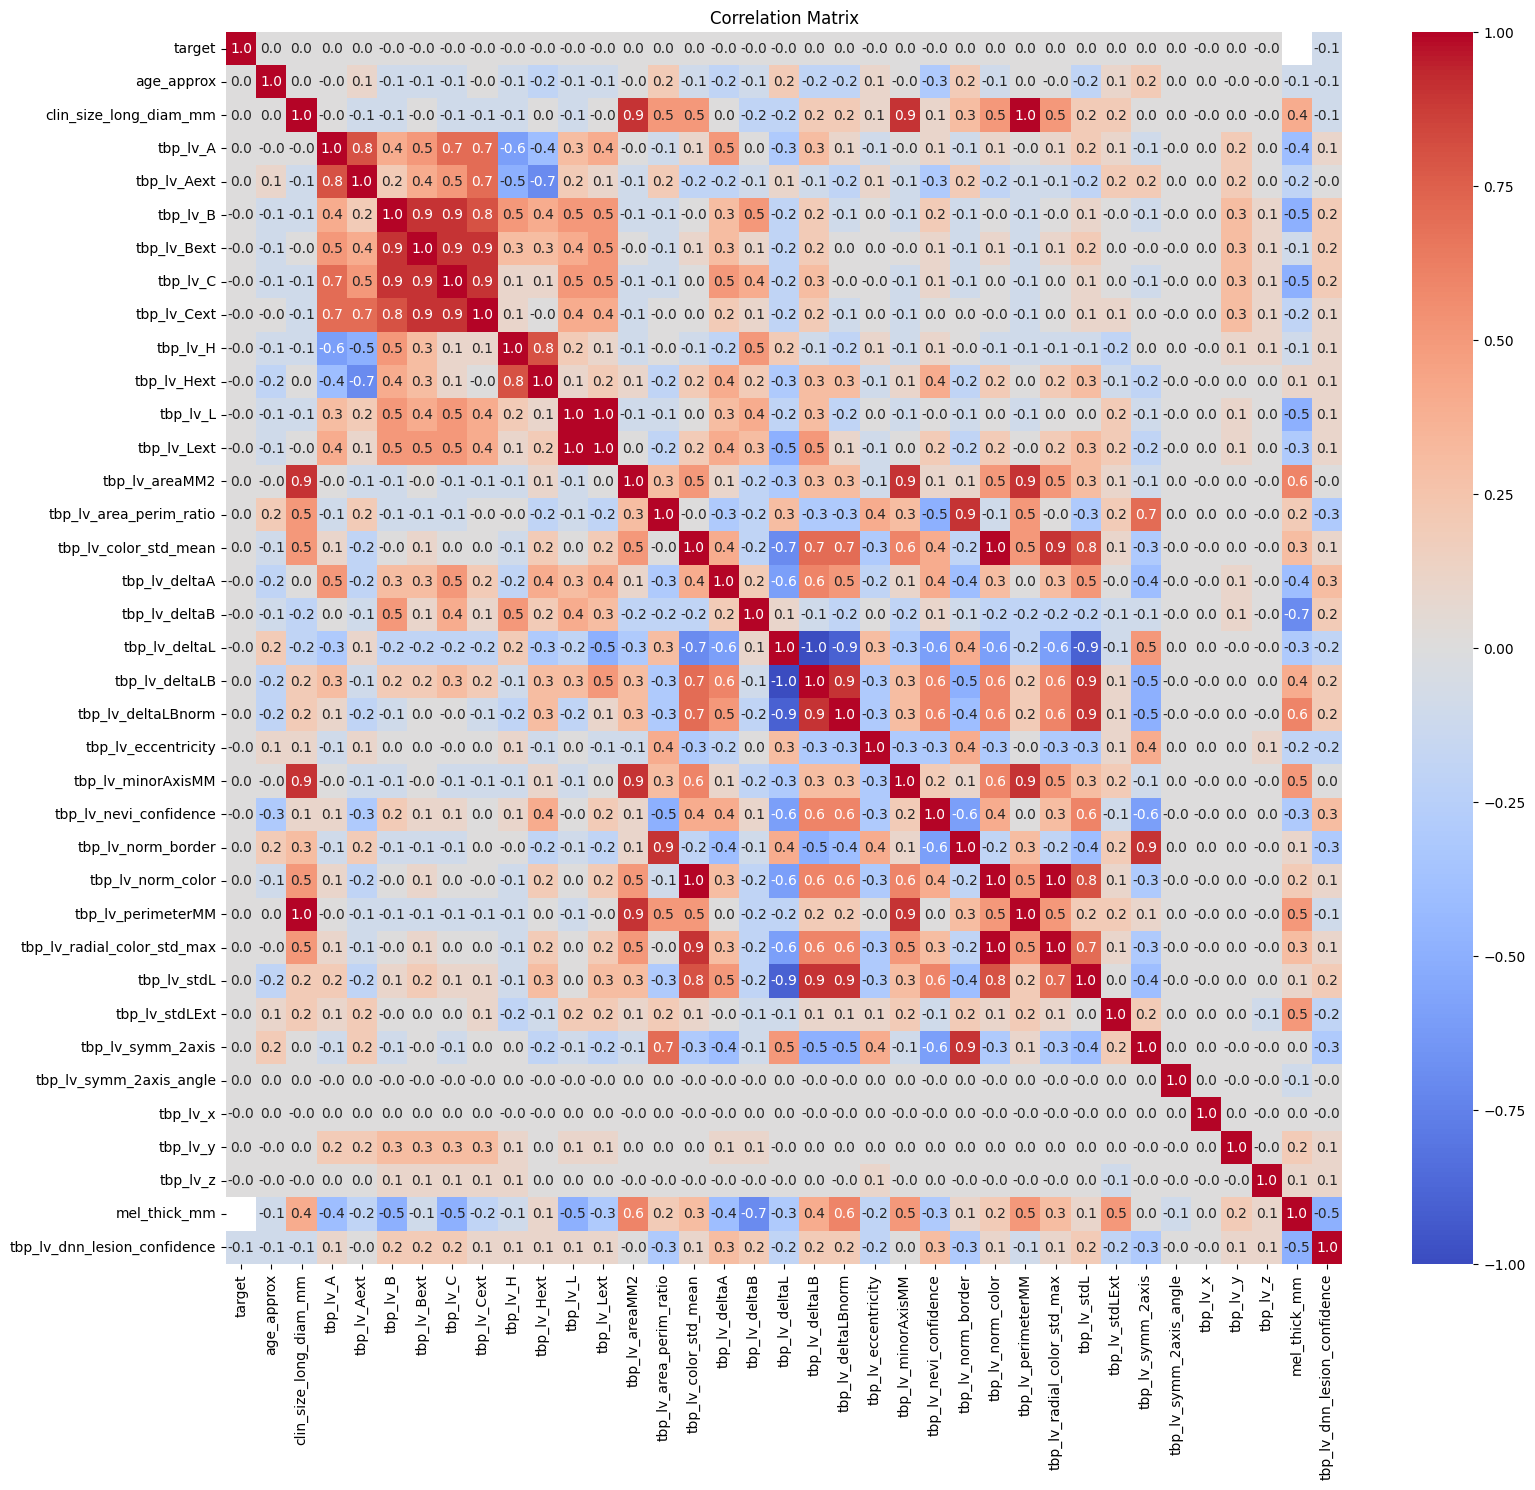

In [6]:
# Correlation heatmap
plt.figure(figsize=(18, 16))
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr().round(1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.show()

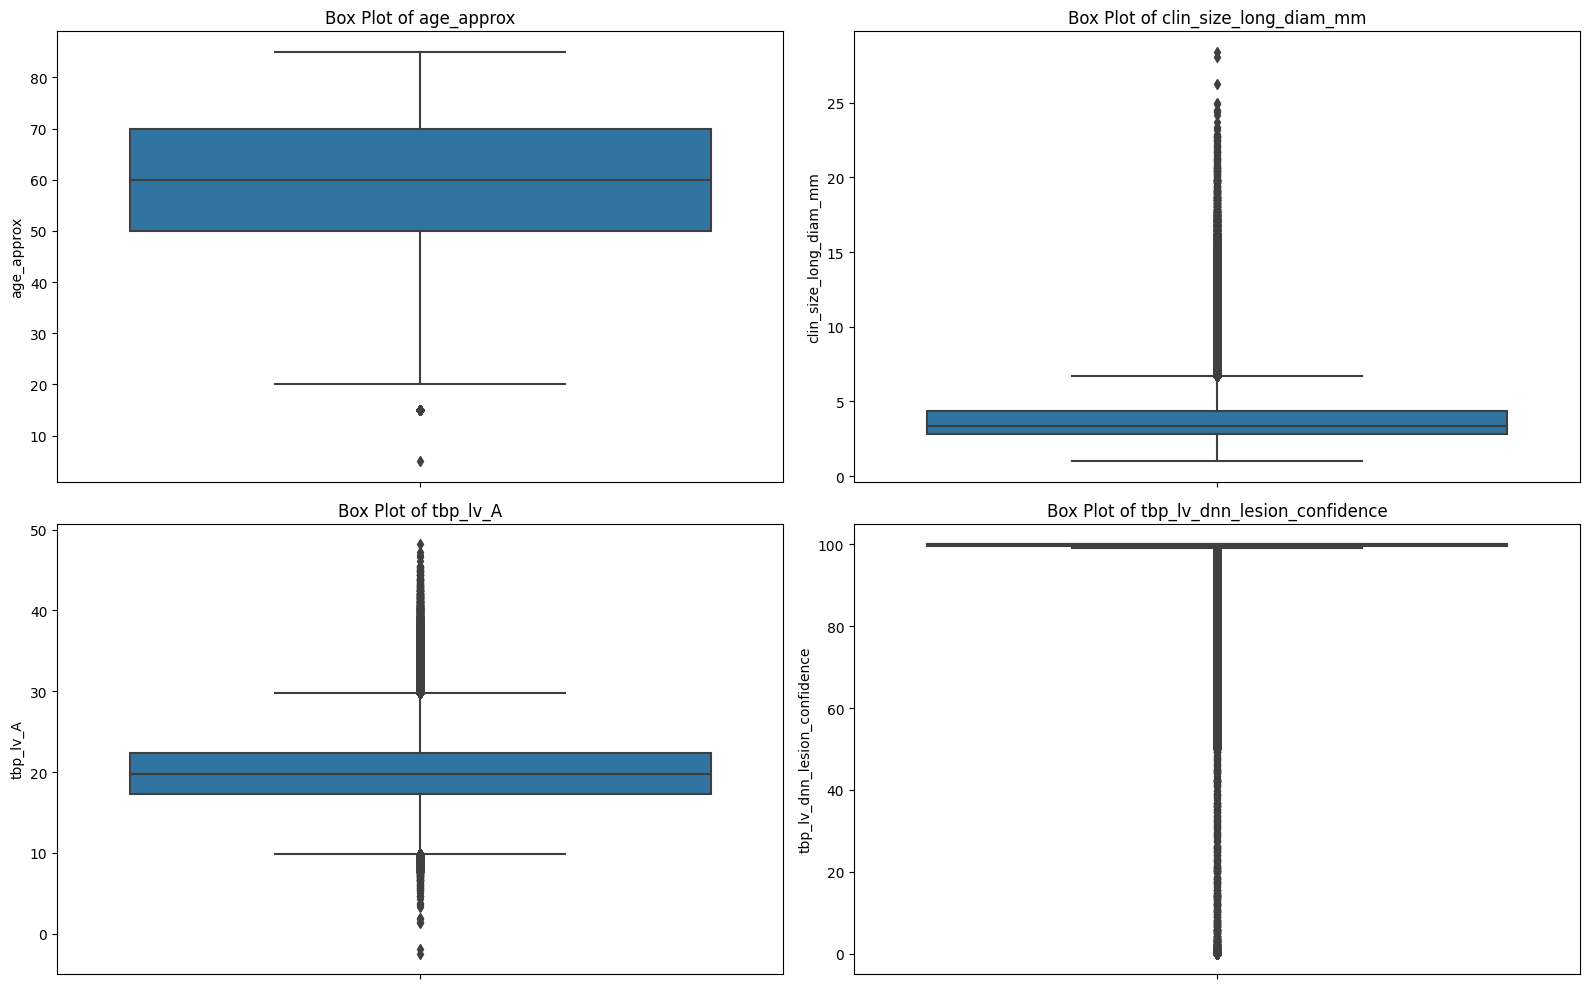

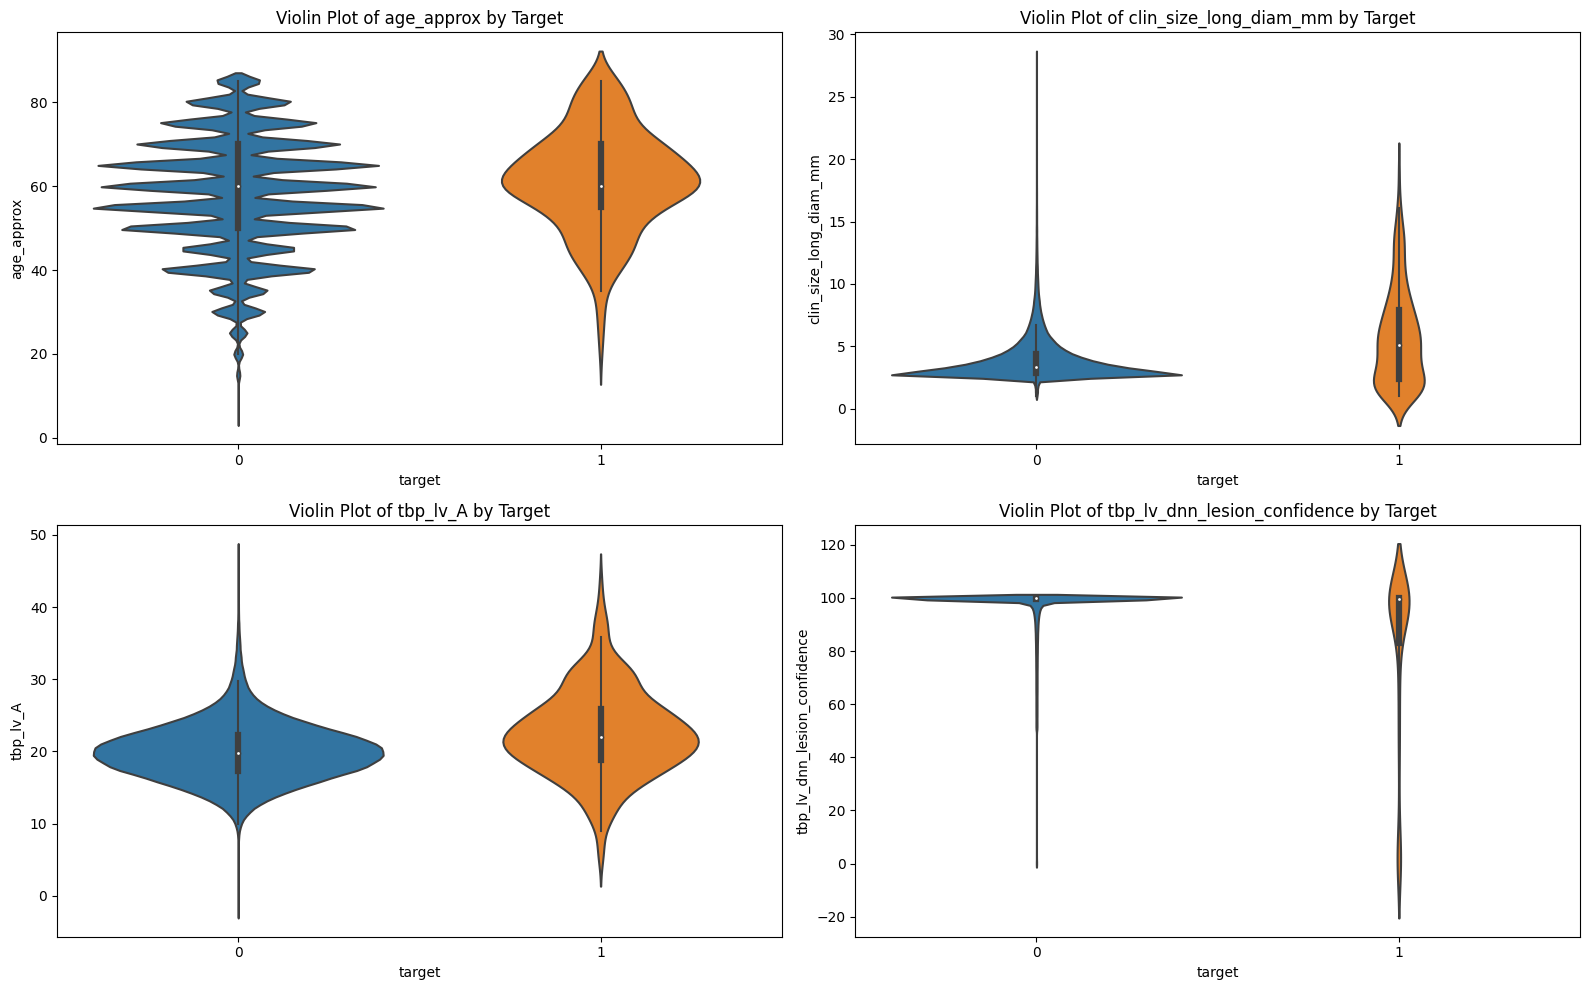

In [7]:
# Box plots for continuous variables
plt.figure(figsize=(16, 10))
continuous_features = ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_dnn_lesion_confidence']
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=feature)
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

# Violin plots for continuous variables by target
plt.figure(figsize=(16, 10))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(data=df, x='target', y=feature)
    plt.title(f'Violin Plot of {feature} by Target')
plt.tight_layout()
plt.show()

In [8]:
# Pairplot
#sns.pairplot(df.dropna(), hue='target')
#plt.suptitle('Pairplot of Features', y=1.02)
#plt.show()


In [9]:
df_train = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
df_test = pd.read_csv("/kaggle/input/isic-2024-challenge/test-metadata.csv")
most_common_patients = df_train['patient_id'].value_counts().head(20)
most_common_patients

/tmp/ipykernel_18/1361232262.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")


patient_id
IP_1117889    9184
IP_5714646    6267
IP_3921915    5568
IP_7797815    4454
IP_9577633    3583
IP_5539318    2859
IP_9853536    2327
IP_5143034    2283
IP_0321326    2245
IP_5426188    2193
IP_1127121    2183
IP_1116526    2121
IP_2331257    1909
IP_6724798    1859
IP_3785831    1852
IP_0658218    1820
IP_5811816    1772
IP_5961877    1610
IP_0869661    1609
IP_3710285    1607
Name: count, dtype: int64

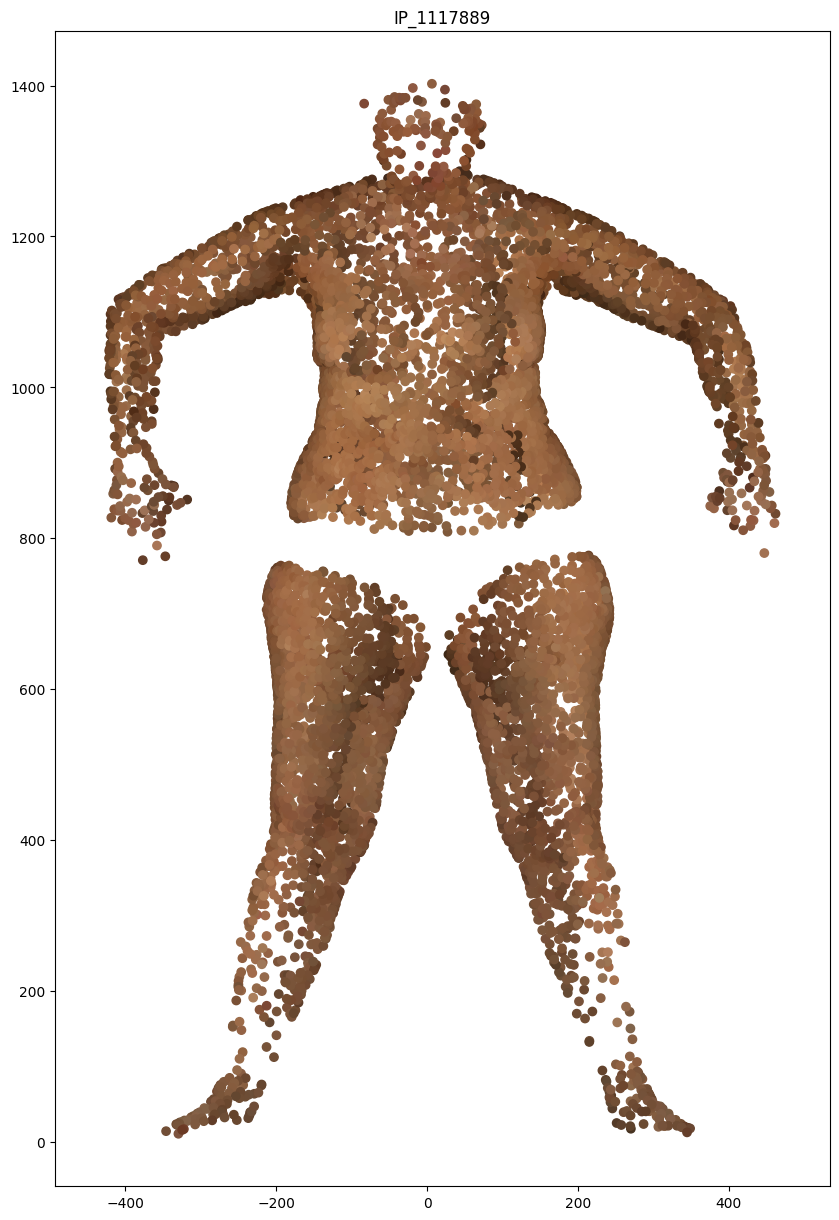

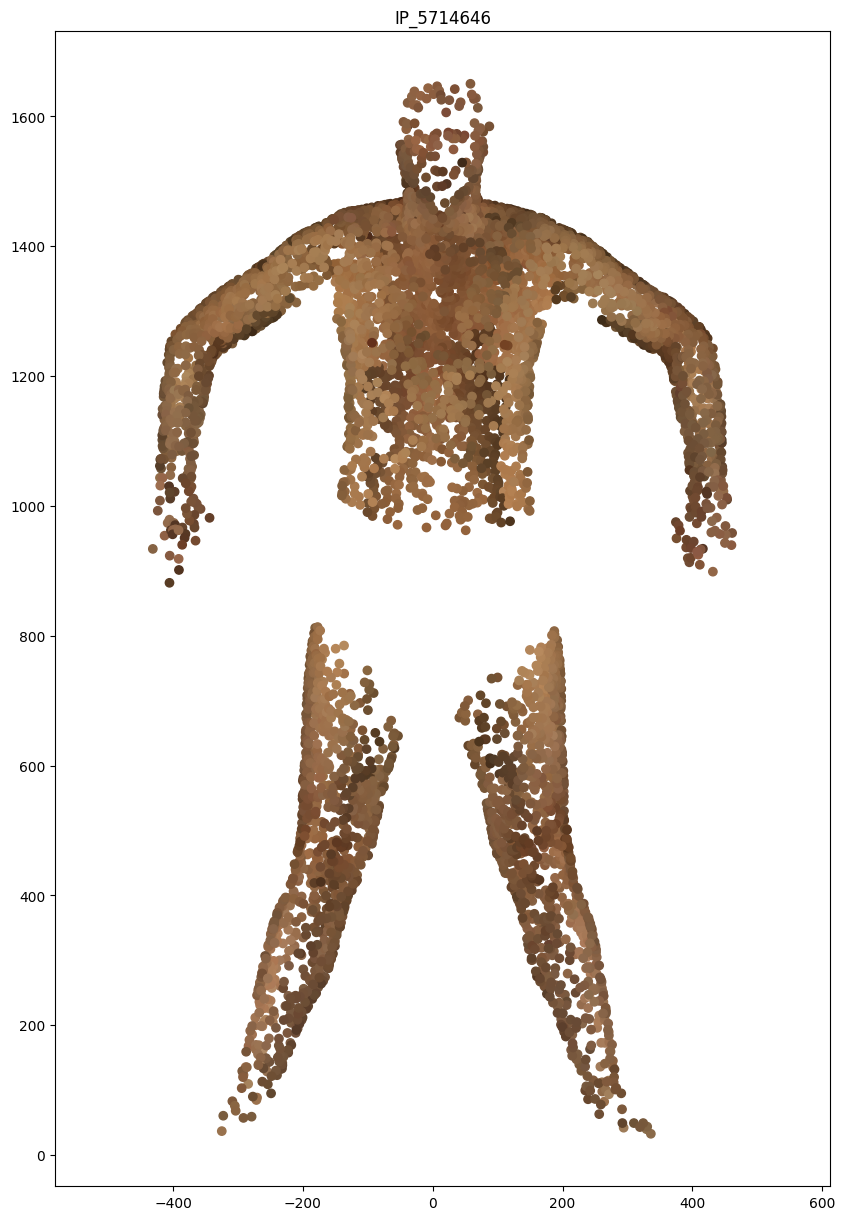

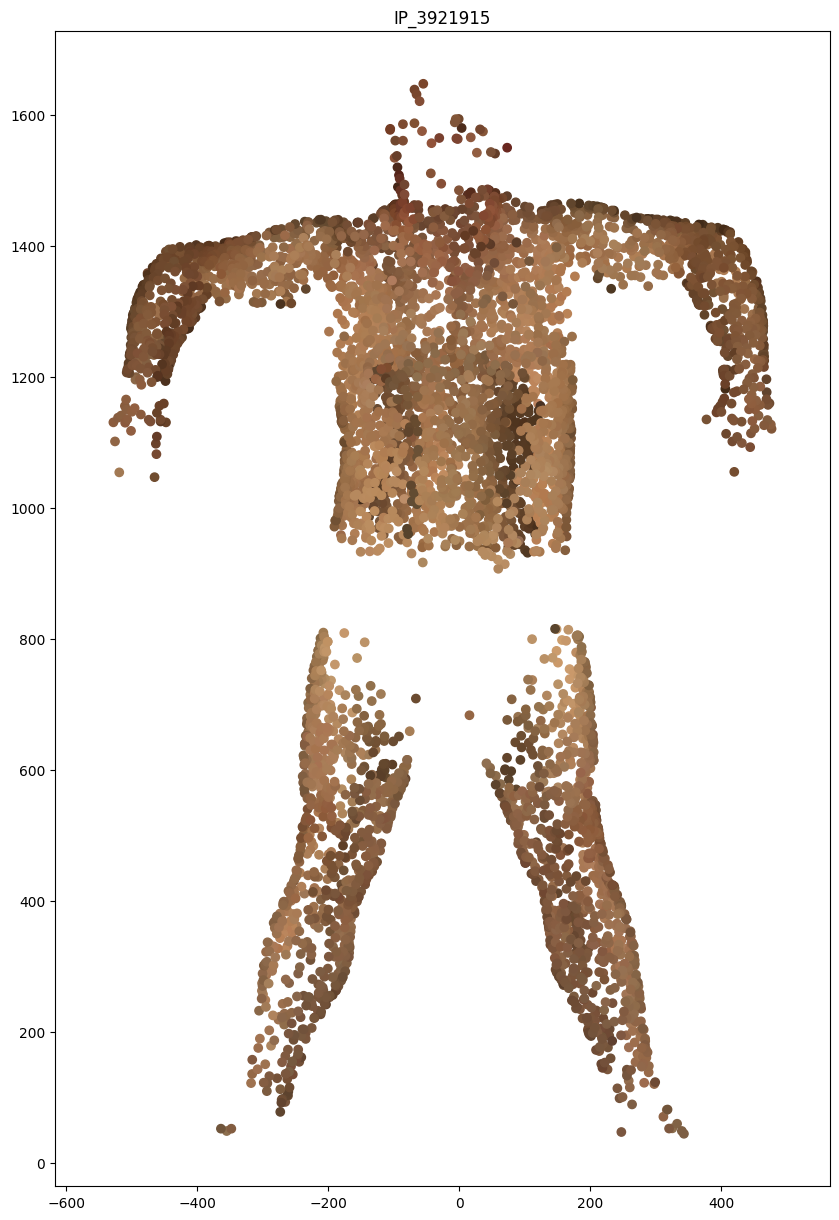

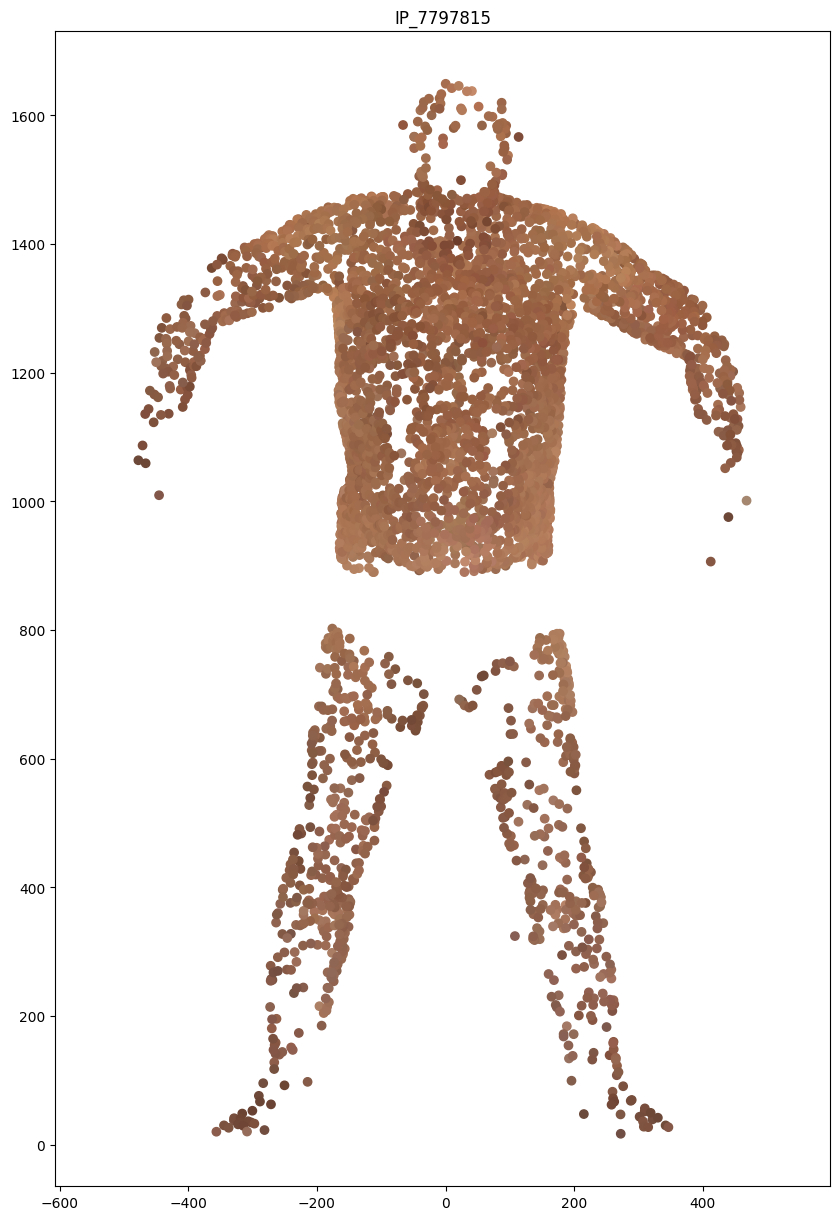

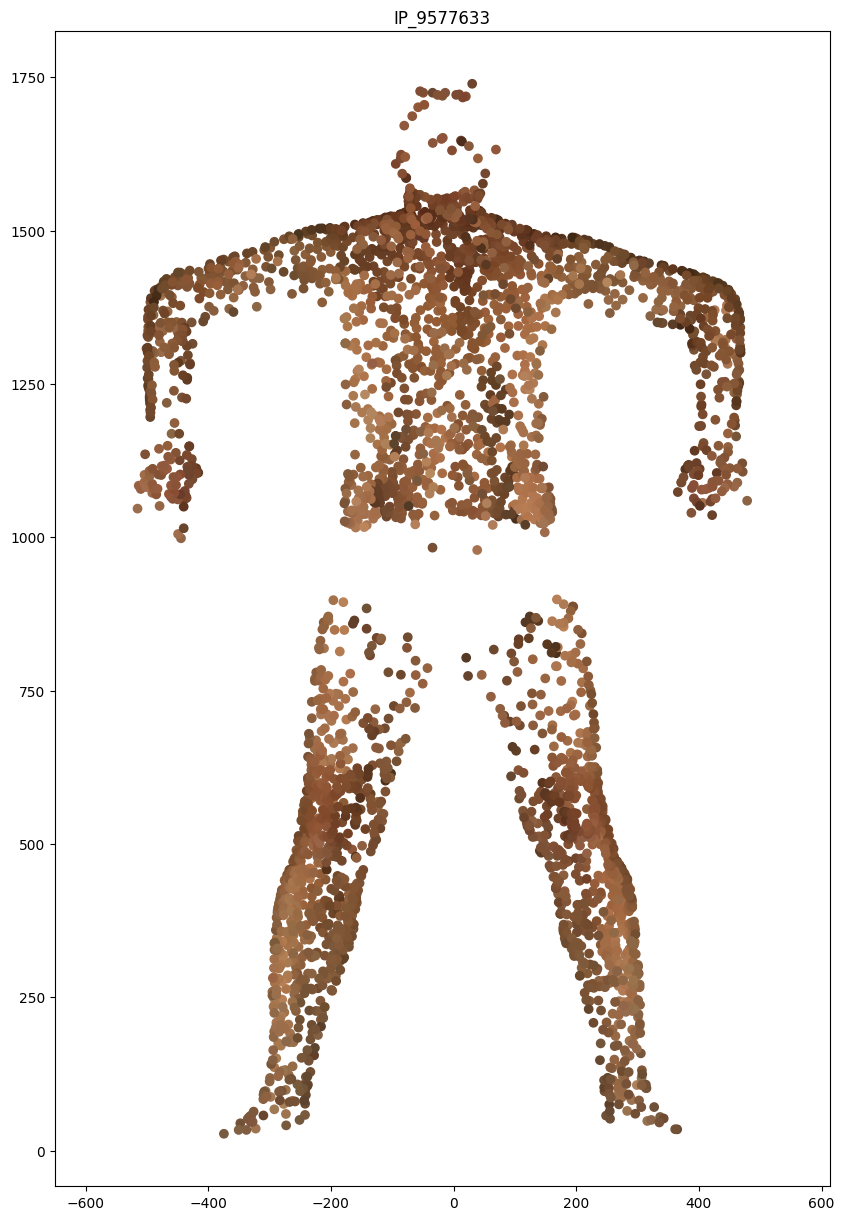

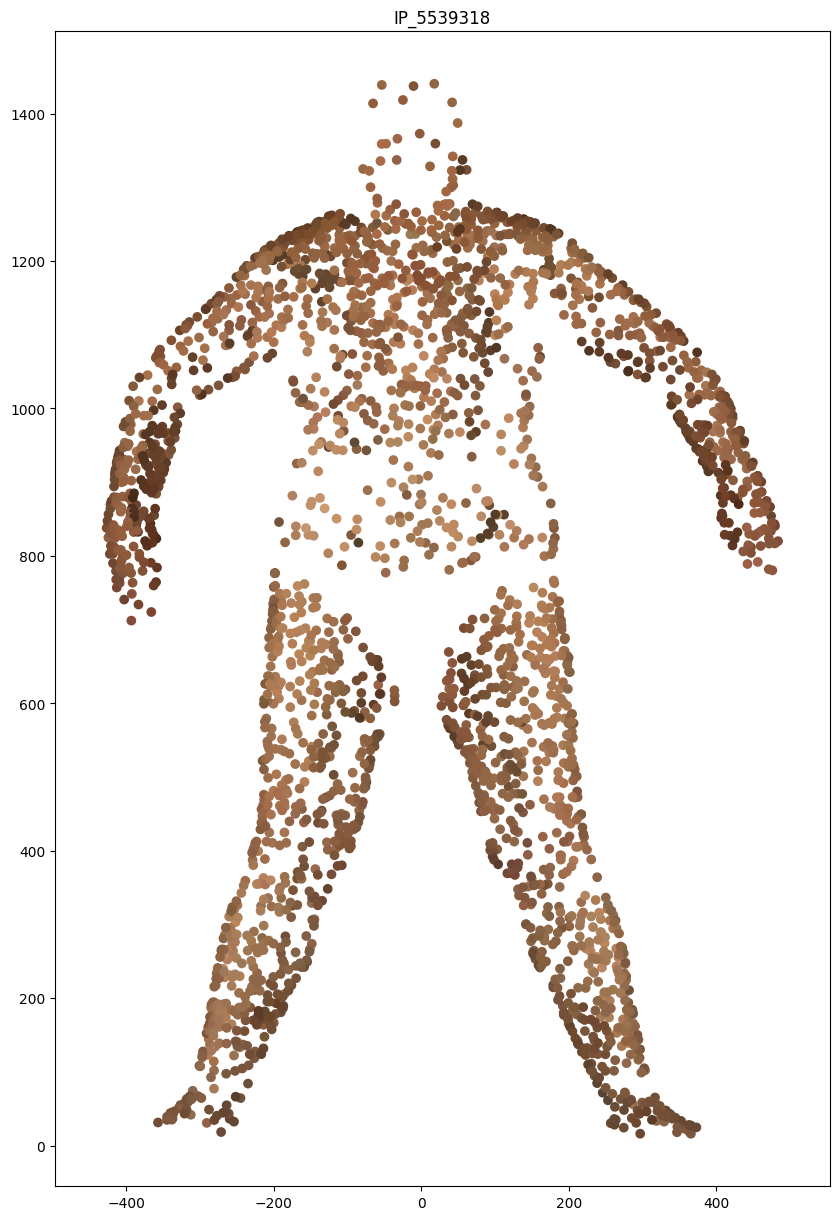

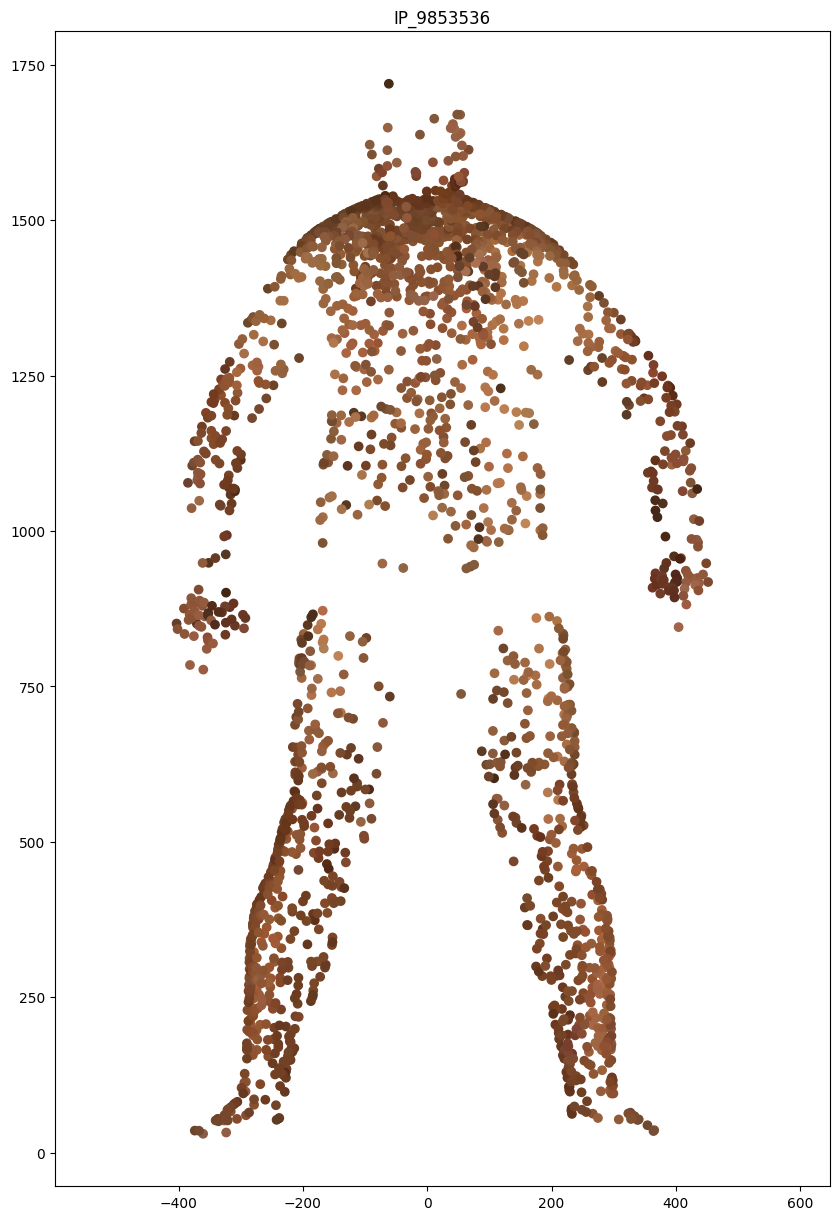

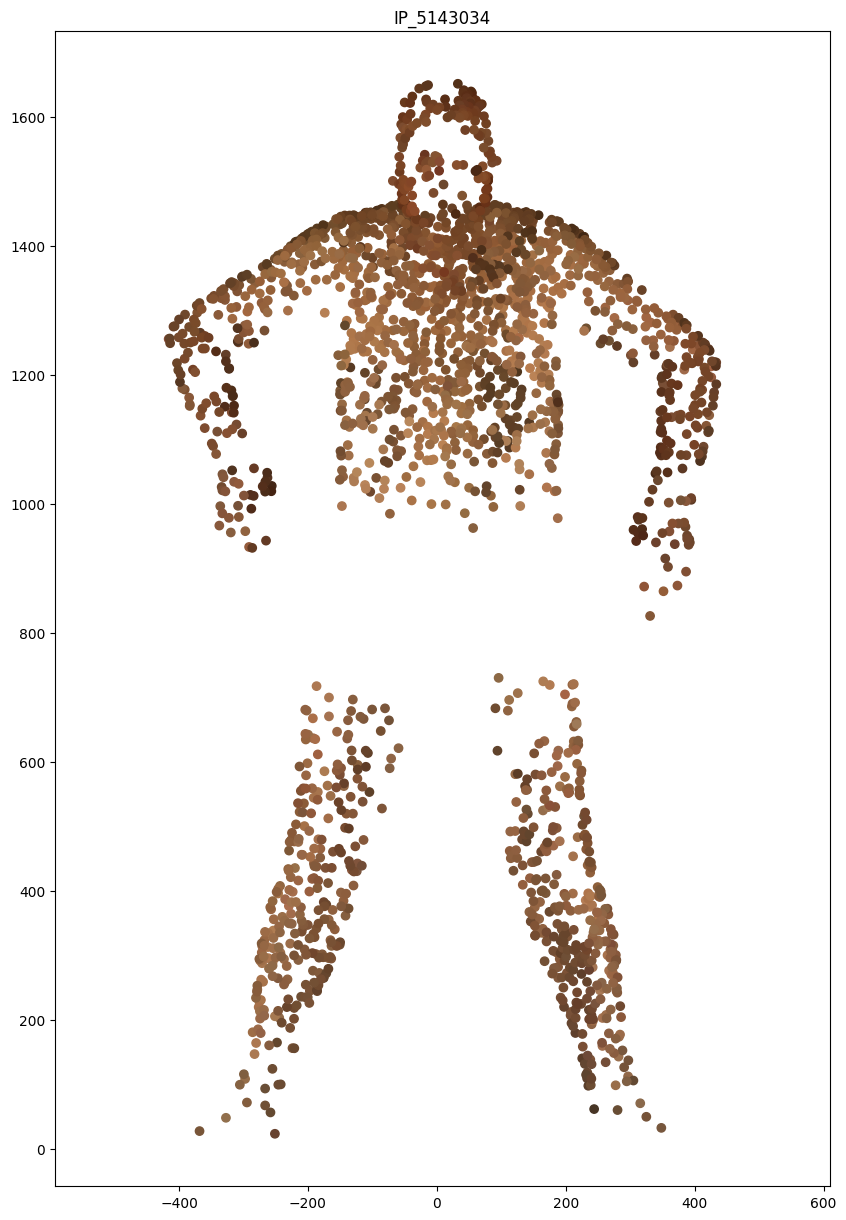

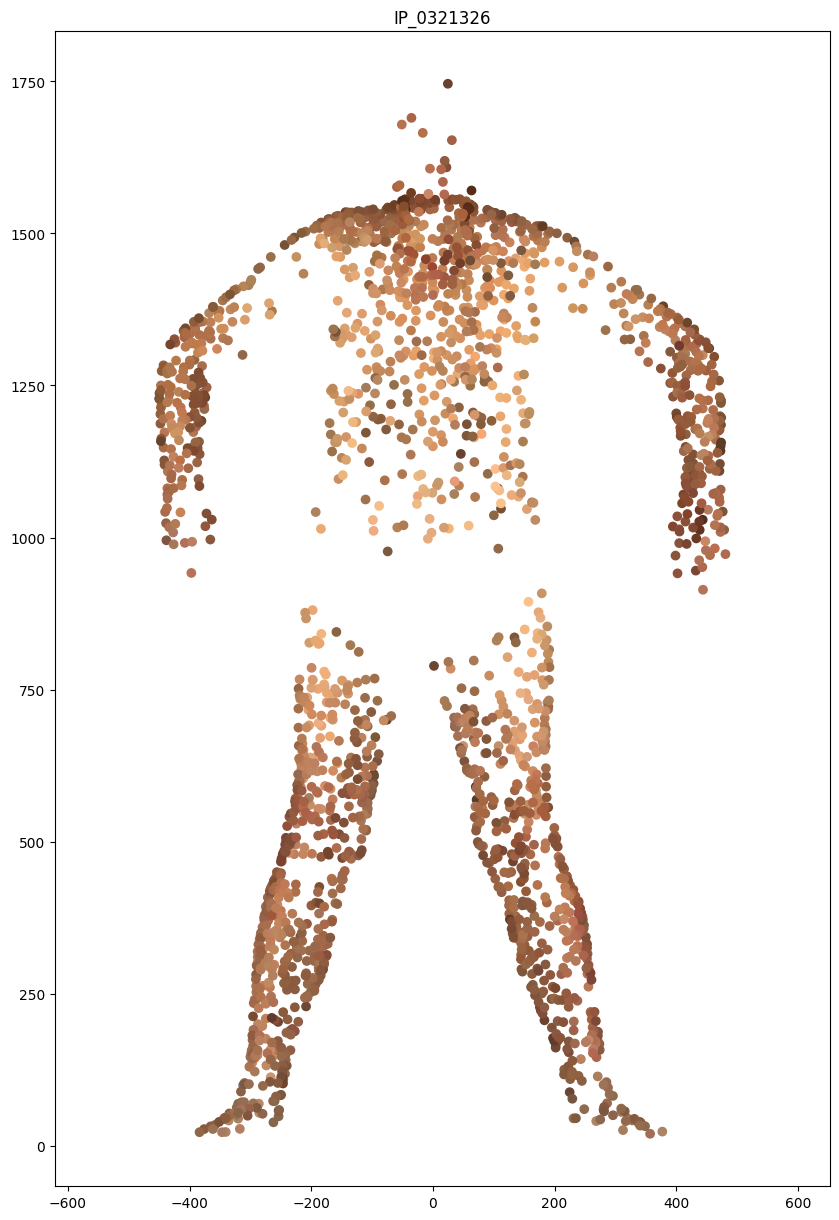

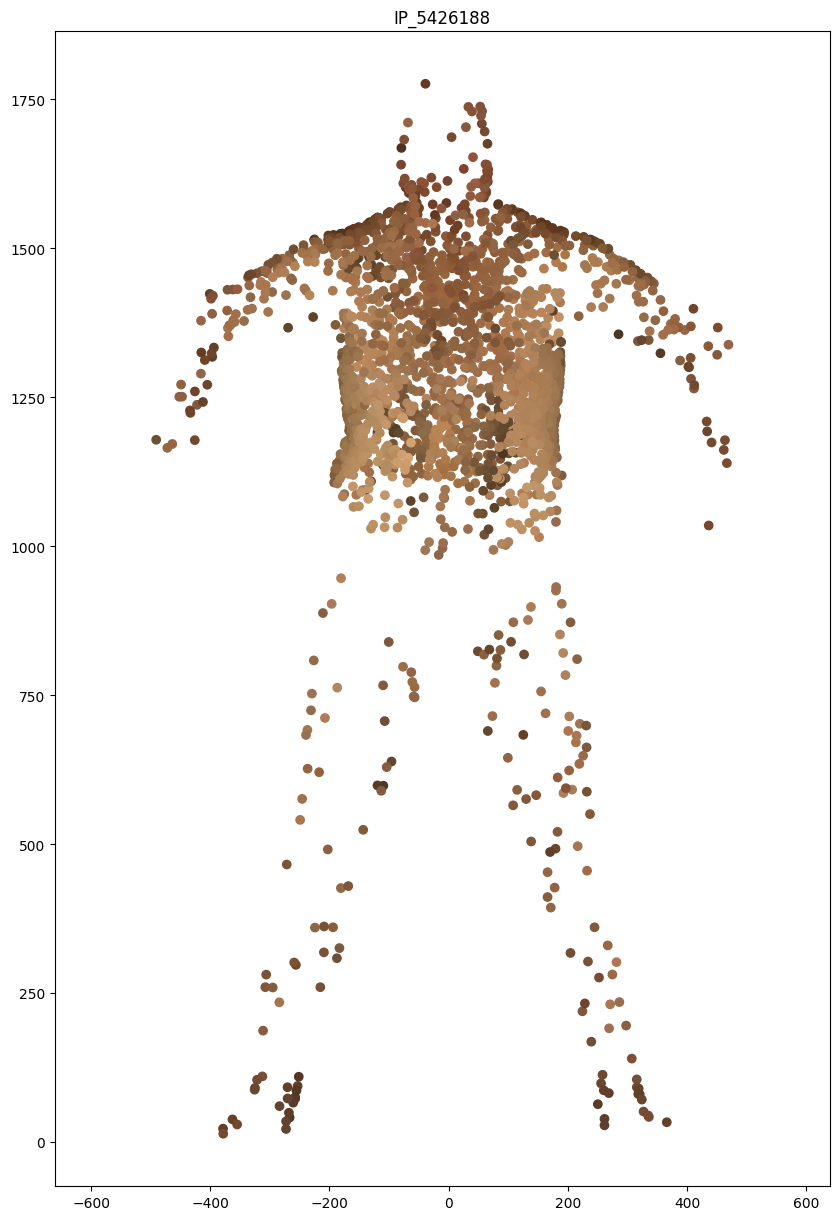

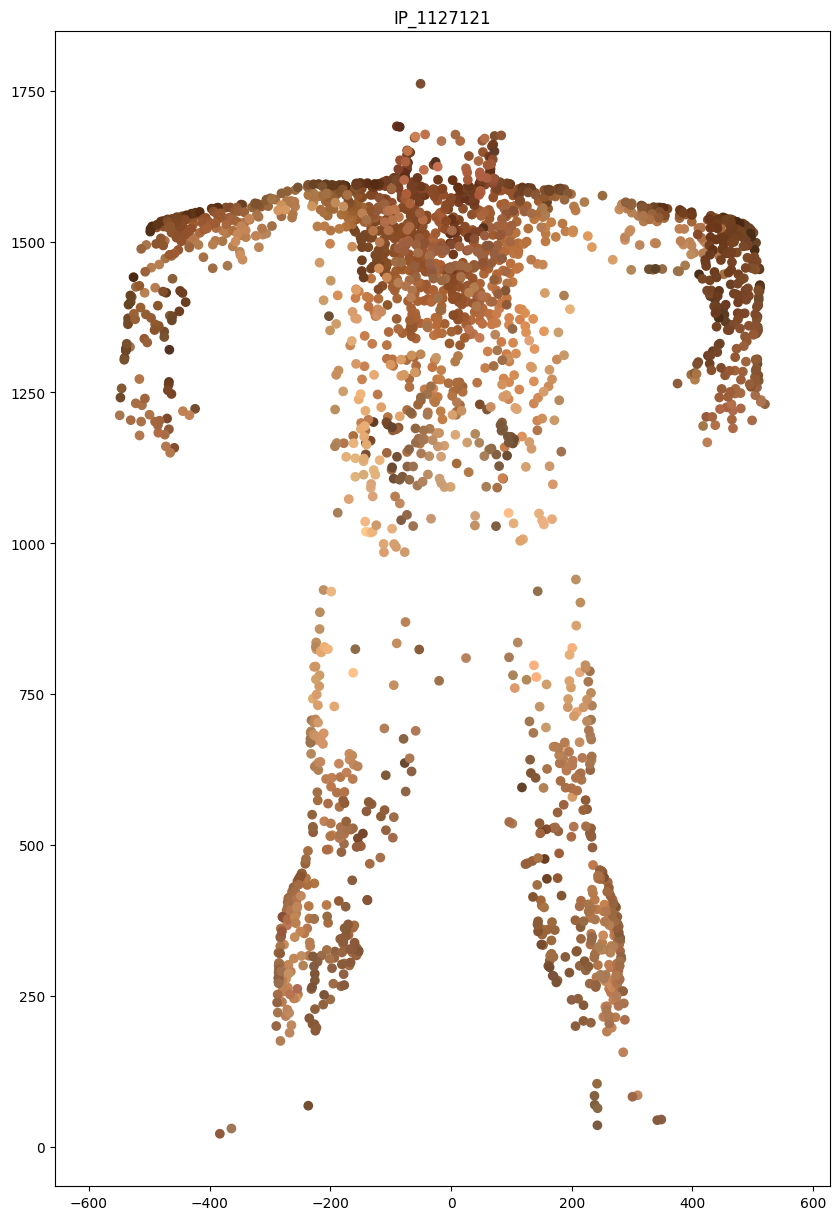

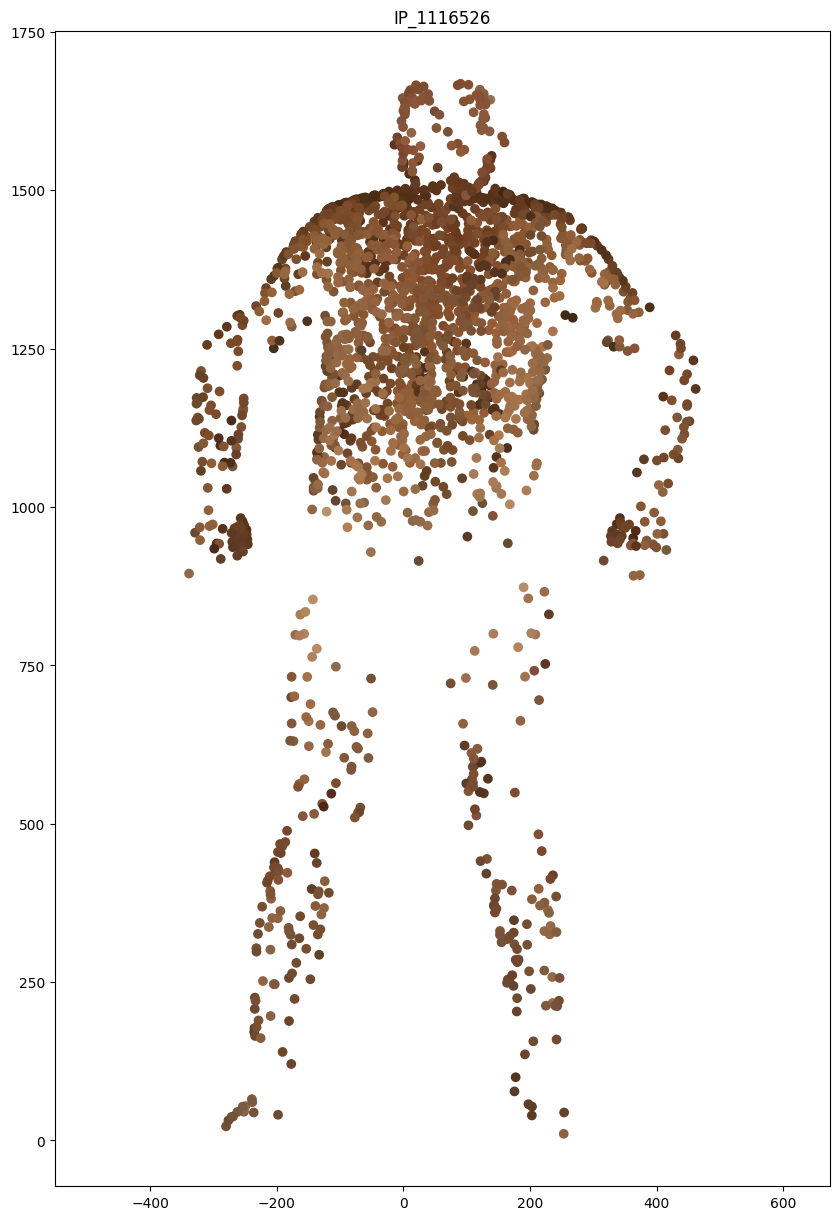

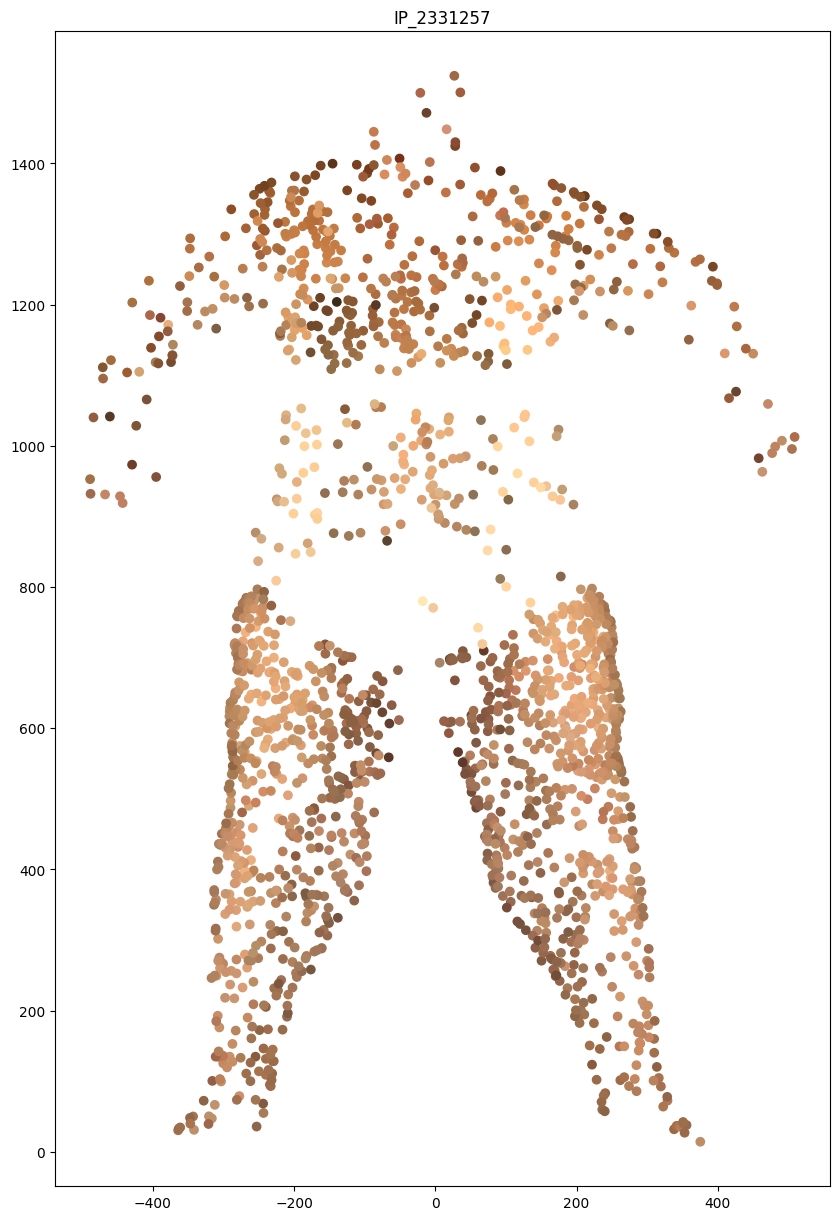

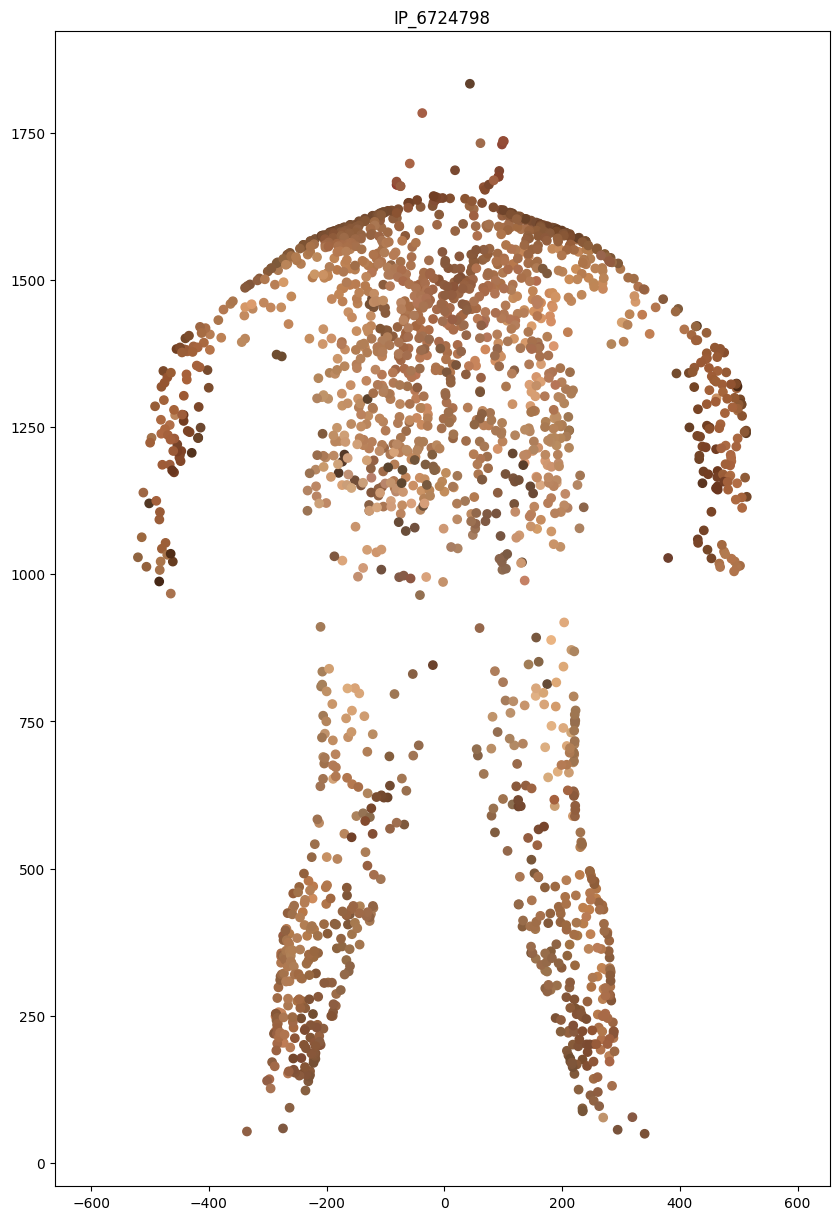

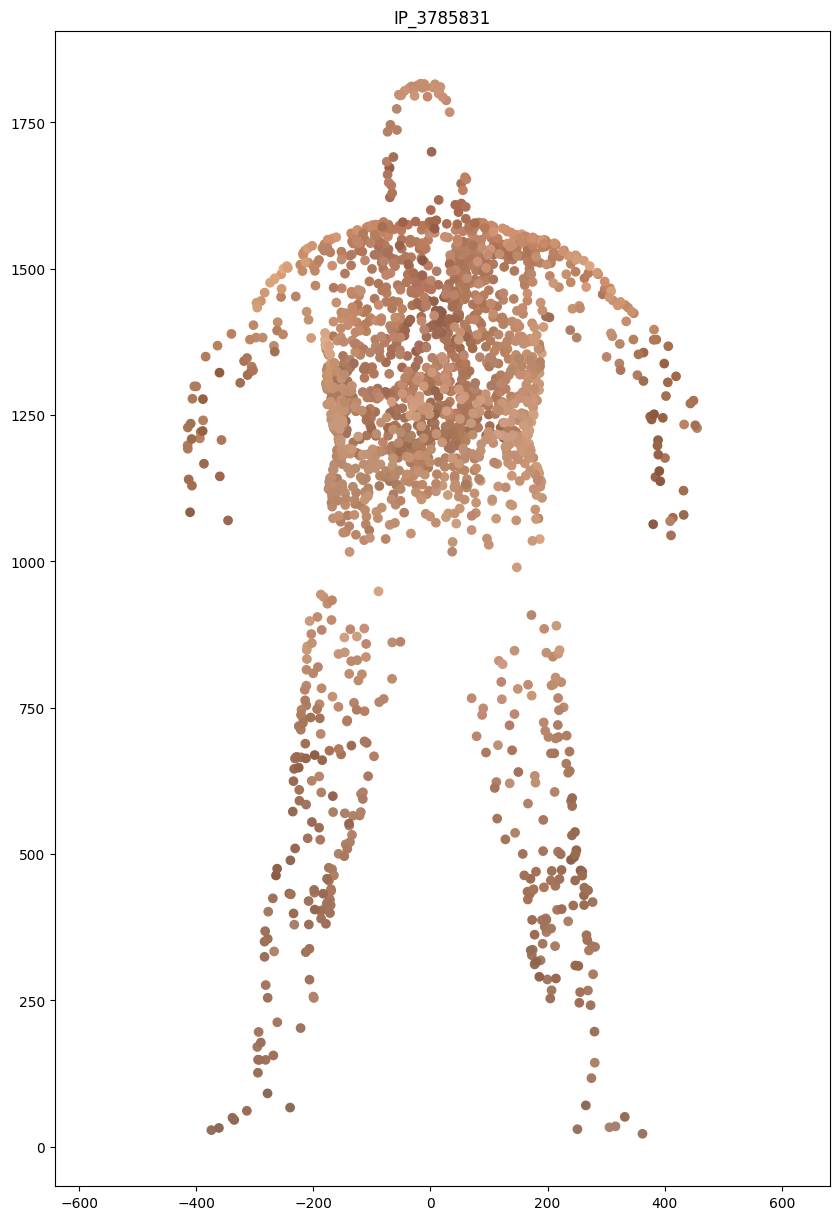

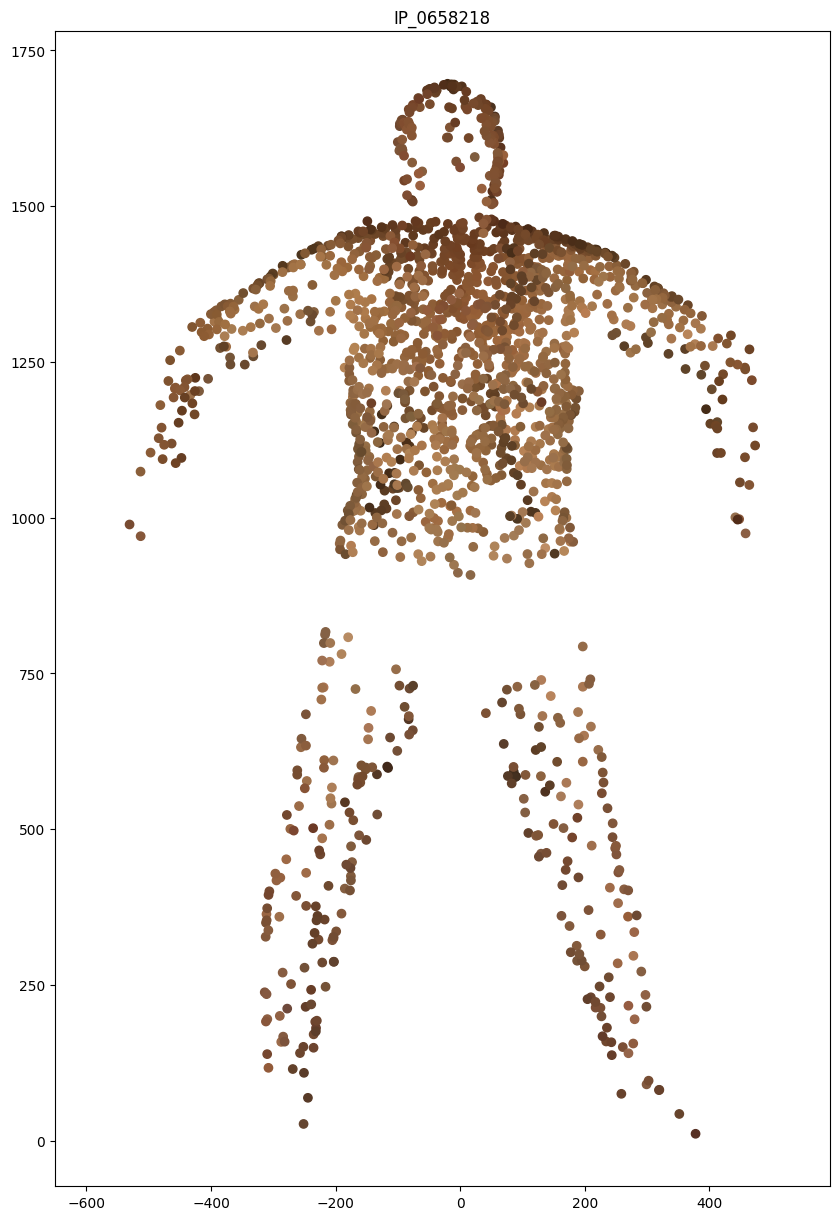

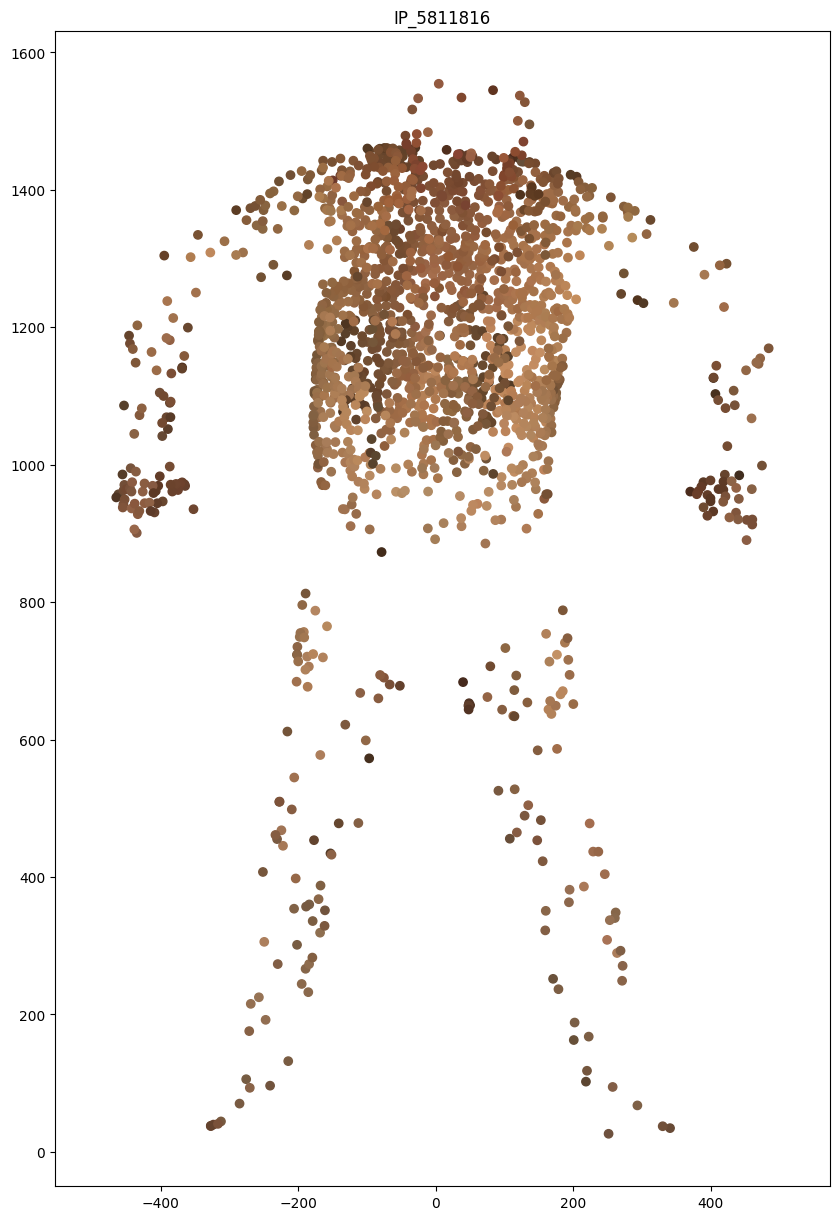

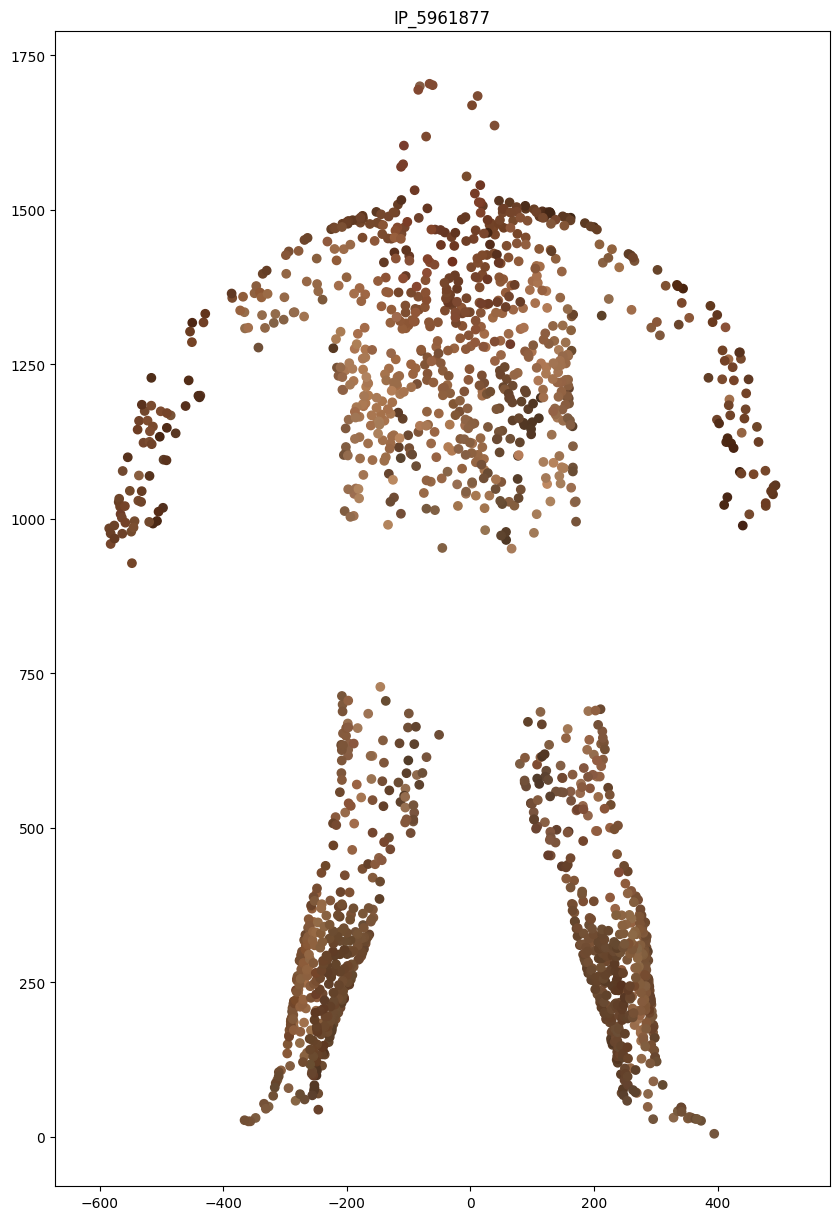

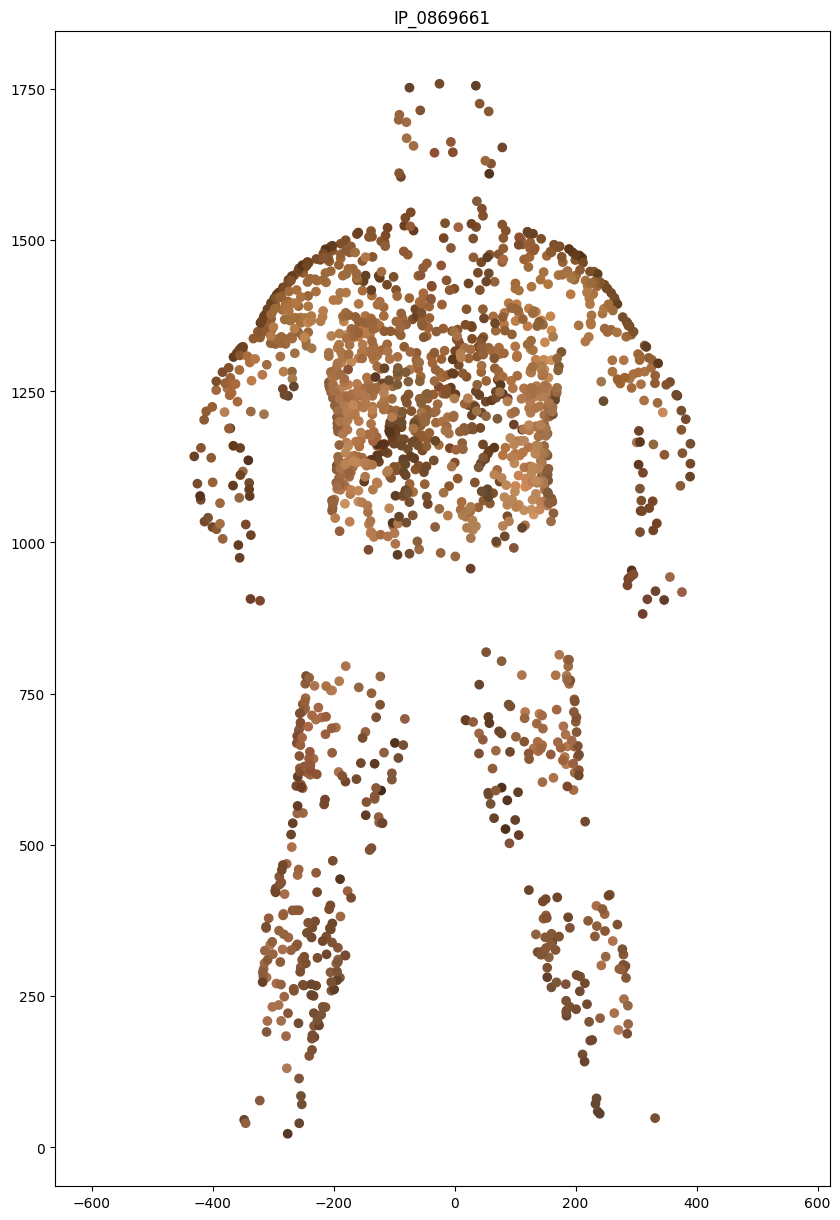

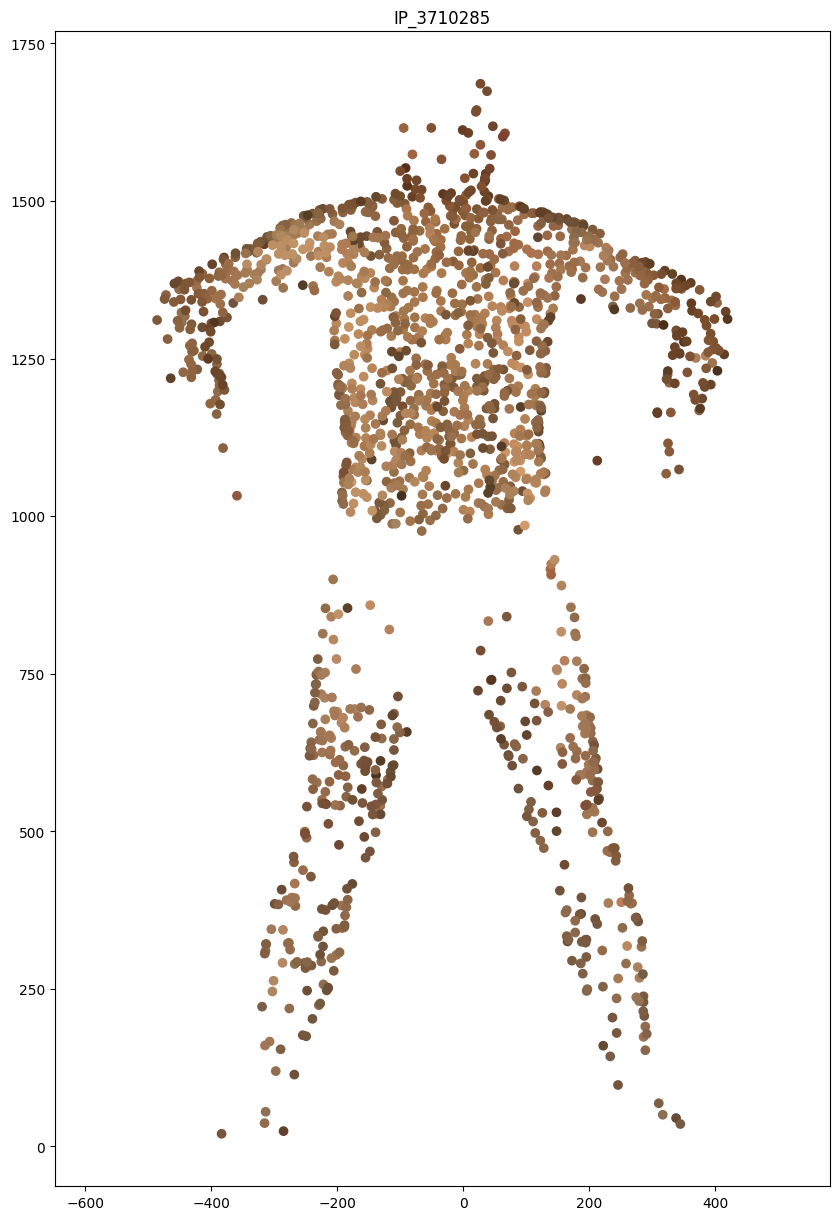

In [10]:
from skimage.color import lab2rgb
for patient_id in most_common_patients.index:
    fig, ax = plt.subplots(figsize=(10, 15))
    # Find by patient_id and sort by z in order to correctly plot
    # frontal samples after back ones
    df_patient = df_train.query('patient_id == @patient_id').sort_values('tbp_lv_z', ascending=False)
    ax.scatter(
        x=df_patient['tbp_lv_x'],
        y=df_patient['tbp_lv_y'],
        c=lab2rgb(df_patient[[
           'tbp_lv_Lext',
           'tbp_lv_Aext',
           'tbp_lv_Bext'
        ]])
    )
    ax.axis('equal')
    ax.set_title(patient_id)
    plt.show()

# LightGBM without Image Features (Only Tabular Data)

In [11]:
def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    # Taken from: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
    df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
    # Until here.
    
    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
        
        "color_variance_ratio", "border_color_interaction", "size_color_contrast_ratio",
        "age_normalized_nevi_confidence", "color_asymmetry_index", "3d_volume_approximation",
        "color_range", "shape_color_consistency", "border_length_ratio", "age_size_symmetry_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
]
df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())
df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _ = feature_engineering(df_test.copy())
num_cols += new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]

In [12]:
N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

In [13]:
def custom_lgbm_metric(y_true, y_hat):
    # TODO: Refactor with the above.
    min_tpr = 0.80
    v_gt = abs(y_true-1)
    v_pred = np.array([1.0 - x for x in y_hat])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return "pauc80", partial_auc, True

 20%|██        | 1/5 [02:31<10:06, 151.62s/it]

fold: 0 - Validation Partial AUC Score: 0.13430


 40%|████      | 2/5 [05:22<08:08, 162.89s/it]

fold: 1 - Validation Partial AUC Score: 0.13555


 60%|██████    | 3/5 [08:14<05:34, 167.06s/it]

fold: 2 - Validation Partial AUC Score: 0.16490


 80%|████████  | 4/5 [11:06<02:49, 169.11s/it]

fold: 3 - Validation Partial AUC Score: 0.16426


100%|██████████| 5/5 [14:01<00:00, 168.22s/it]

fold: 4 - Validation Partial AUC Score: 0.18028
Final Training Accuracy: 0.99987
Final Validation Accuracy: 0.99902
Final Test Accuracy: 0.99900


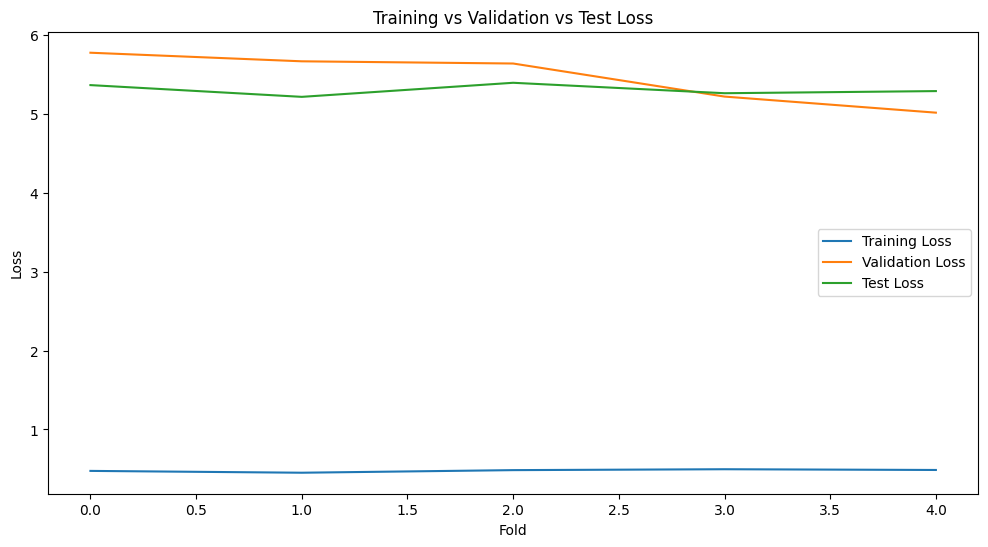

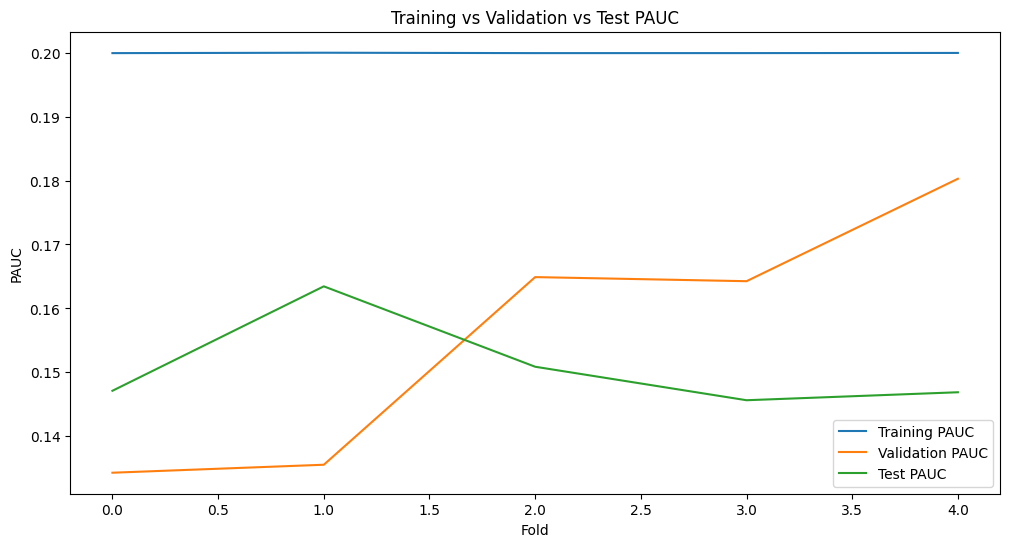

In [14]:
new_params =  {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_estimators": 200,
    'learning_rate': 0.05,    
    'lambda_l1': 0.0004681884533249742, 
    'lambda_l2': 8.765240856362274, 
    'num_leaves': 136, 
    'feature_fraction': 0.5392005444882538, 
    'bagging_fraction': 0.9577412548866563, 
    'bagging_freq': 6,
    'min_child_samples': 60,
    #"device": "gpu"
}

'''
{
    'objective': 'binary',
    "n_estimators":1400,
    'learning_rate':0.003,
    'num_leaves':30,
    'min_data_in_leaf':40,
    'bagging_freq': 1,
    'pos_bagging_fraction':0.74,
    'neg_bagging_fraction':0.04,
    'feature_fraction':0.77,
    'lambda_l1':0.21,
    'lambda_l2':1.47,
    "verbosity": -1,
    # "extra_trees": True
}
'''



train_data, temp_data = train_test_split(df_train, test_size=0.15, stratify=df_train["target"], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, stratify=temp_data["target"], random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_data["fold"] = -1
gkf = GroupKFold(n_splits=N_SPLITS)
for idx, (train_idx, val_idx) in enumerate(gkf.split(train_data, train_data["target"], groups=train_data["patient_id"])):
    train_data.loc[val_idx, "fold"] = idx

train_accuracies = []
val_accuracies = []
test_accuracies = []
train_losses = []
val_losses = []
test_losses = []
train_pauc = []
val_pauc = []
test_pauc = []

lgb_models = []

for fold in tqdm(range(N_SPLITS)):
    _df_train = train_data[train_data["fold"] != fold].reset_index(drop=True)
    _df_valid = train_data[train_data["fold"] == fold].reset_index(drop=True)
    
    model = VotingClassifier([(f"lgb_{i}", lgb.LGBMClassifier(random_state=i, **new_params)) for i in range(3)], voting="soft")
    model.fit(_df_train[train_cols], _df_train["target"])
    
    # Training set evaluation
    train_preds = model.predict_proba(_df_train[train_cols])[:, 1]
    train_accuracy = accuracy_score(_df_train["target"], (train_preds > 0.5).astype(int))
    train_loss = -np.mean(np.log(train_preds[_df_train["target"] == 1])) - np.mean(np.log(1 - train_preds[_df_train["target"] == 0]))
    _, train_pauc_score, _ = custom_lgbm_metric(_df_train["target"], train_preds)
    
    # Validation set evaluation
    val_preds = model.predict_proba(_df_valid[train_cols])[:, 1]
    val_accuracy = accuracy_score(_df_valid["target"], (val_preds > 0.5).astype(int))
    val_loss = -np.mean(np.log(val_preds[_df_valid["target"] == 1])) - np.mean(np.log(1 - val_preds[_df_valid["target"] == 0]))
    _, val_pauc_score, _ = custom_lgbm_metric(_df_valid["target"], val_preds)
    
    # Test set evaluation
    test_preds = model.predict_proba(test_data[train_cols])[:, 1]
    test_accuracy = accuracy_score(test_data["target"], (test_preds > 0.5).astype(int))
    test_loss = -np.mean(np.log(test_preds[test_data["target"] == 1])) - np.mean(np.log(1 - test_preds[test_data["target"] == 0]))
    _, test_pauc_score, _ = custom_lgbm_metric(test_data["target"], test_preds)
    
    print(f"fold: {fold} - Validation Partial AUC Score: {val_pauc_score:.5f}")
    
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_pauc.append(train_pauc_score)
    val_pauc.append(val_pauc_score)
    test_pauc.append(test_pauc_score)
    
    lgb_models.append(model)

print(f"Final Training Accuracy: {np.mean(train_accuracies):.5f}")
print(f"Final Validation Accuracy: {np.mean(val_accuracies):.5f}")
print(f"Final Test Accuracy: {np.mean(test_accuracies):.5f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(N_SPLITS), train_losses, label='Training Loss')
plt.plot(range(N_SPLITS), val_losses, label='Validation Loss')
plt.plot(range(N_SPLITS), test_losses, label='Test Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Training vs Validation vs Test Loss')
plt.legend()
plt.show()

# Plot training vs validation PAUC
plt.figure(figsize=(12, 6))
plt.plot(range(N_SPLITS), train_pauc, label='Training PAUC')
plt.plot(range(N_SPLITS), val_pauc, label='Validation PAUC')
plt.plot(range(N_SPLITS), test_pauc, label='Test PAUC')
plt.xlabel('Fold')
plt.ylabel('PAUC')
plt.title('Training vs Validation vs Test PAUC')
plt.legend()
plt.show()

In [15]:
lgbm_score = np.mean(val_pauc)
print(f"LGBM Score: {lgbm_score:.5f}")

LGBM Score: 0.15586


# LightGBM with Image Features

In [16]:
df_eff = pd.read_csv("/kaggle/input/effnet/train_eff_2024.csv")
df_eff = df_eff[["target_eff"]]
gc.collect()

/tmp/ipykernel_18/4087464698.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eff = pd.read_csv("/kaggle/input/effnet/train_eff_2024.csv")


43743

In [17]:
df_train["target_eff"] = df_eff["target_eff"]
train_cols += ["target_eff"]
del df_eff
gc.collect()

0

 20%|██        | 1/5 [02:22<09:31, 142.80s/it]

fold: 0 - Validation Partial AUC Score: 0.17270


 40%|████      | 2/5 [04:51<07:17, 145.99s/it]

fold: 1 - Validation Partial AUC Score: 0.18752


 60%|██████    | 3/5 [07:19<04:53, 146.93s/it]

fold: 2 - Validation Partial AUC Score: 0.18680


 80%|████████  | 4/5 [09:45<02:26, 146.73s/it]

fold: 3 - Validation Partial AUC Score: 0.18798


100%|██████████| 5/5 [12:10<00:00, 146.15s/it]

fold: 4 - Validation Partial AUC Score: 0.18521
Final Training Accuracy: 0.99990
Final Validation Accuracy: 0.99901
Final Test Accuracy: 0.99900


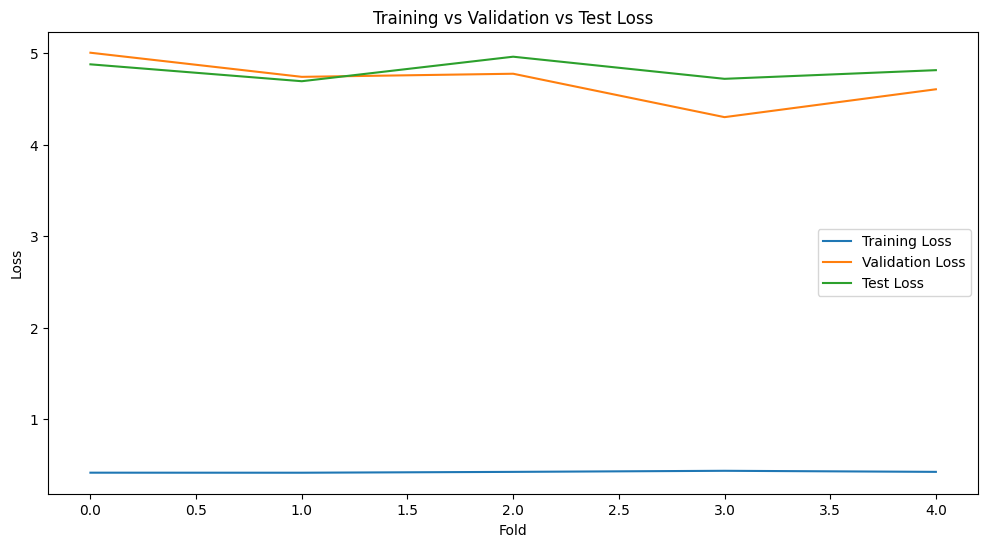

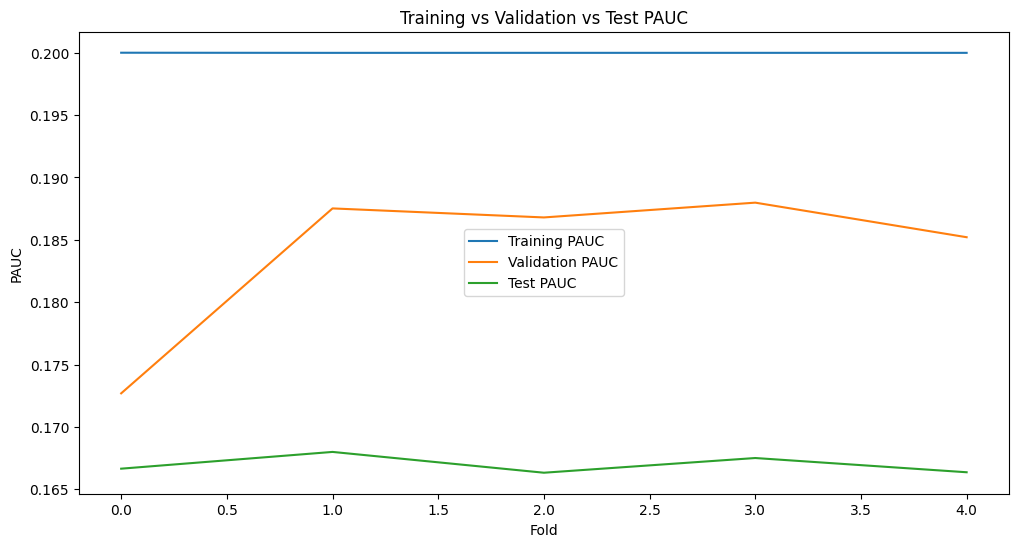

In [18]:
new_params =  {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_estimators": 200,
    'learning_rate': 0.05,    
    'lambda_l1': 0.0004681884533249742, 
    'lambda_l2': 8.765240856362274, 
    'num_leaves': 136, 
    'feature_fraction': 0.5392005444882538, 
    'bagging_fraction': 0.9577412548866563, 
    'bagging_freq': 6,
    'min_child_samples': 60,
    #"device": "gpu"
}

'''
{
    'objective': 'binary',
    "n_estimators":1400,
    'learning_rate':0.003,
    'num_leaves':30,
    'min_data_in_leaf':40,
    'bagging_freq': 1,
    'pos_bagging_fraction':0.74,
    'neg_bagging_fraction':0.04,
    'feature_fraction':0.77,
    'lambda_l1':0.21,
    'lambda_l2':1.47,
    "verbosity": -1,
    # "extra_trees": True
}
'''



train_data, temp_data = train_test_split(df_train, test_size=0.15, stratify=df_train["target"], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, stratify=temp_data["target"], random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_data["fold"] = -1
gkf = GroupKFold(n_splits=N_SPLITS)
for idx, (train_idx, val_idx) in enumerate(gkf.split(train_data, train_data["target"], groups=train_data["patient_id"])):
    train_data.loc[val_idx, "fold"] = idx

train_accuracies = []
val_accuracies = []
test_accuracies = []
train_losses = []
val_losses = []
test_losses = []
train_pauc = []
val_pauc = []
test_pauc = []

lgb_models = []

for fold in tqdm(range(N_SPLITS)):
    _df_train = train_data[train_data["fold"] != fold].reset_index(drop=True)
    _df_valid = train_data[train_data["fold"] == fold].reset_index(drop=True)
    
    model = VotingClassifier([(f"lgb_{i}", lgb.LGBMClassifier(random_state=i, **new_params)) for i in range(3)], voting="soft")
    model.fit(_df_train[train_cols], _df_train["target"])
    
    # Training set evaluation
    train_preds = model.predict_proba(_df_train[train_cols])[:, 1]
    train_accuracy = accuracy_score(_df_train["target"], (train_preds > 0.5).astype(int))
    train_loss = -np.mean(np.log(train_preds[_df_train["target"] == 1])) - np.mean(np.log(1 - train_preds[_df_train["target"] == 0]))
    _, train_pauc_score, _ = custom_lgbm_metric(_df_train["target"], train_preds)
    
    # Validation set evaluation
    val_preds = model.predict_proba(_df_valid[train_cols])[:, 1]
    val_accuracy = accuracy_score(_df_valid["target"], (val_preds > 0.5).astype(int))
    val_loss = -np.mean(np.log(val_preds[_df_valid["target"] == 1])) - np.mean(np.log(1 - val_preds[_df_valid["target"] == 0]))
    _, val_pauc_score, _ = custom_lgbm_metric(_df_valid["target"], val_preds)
    
    # Test set evaluation
    test_preds = model.predict_proba(test_data[train_cols])[:, 1]
    test_accuracy = accuracy_score(test_data["target"], (test_preds > 0.5).astype(int))
    test_loss = -np.mean(np.log(test_preds[test_data["target"] == 1])) - np.mean(np.log(1 - test_preds[test_data["target"] == 0]))
    _, test_pauc_score, _ = custom_lgbm_metric(test_data["target"], test_preds)
    
    print(f"fold: {fold} - Validation Partial AUC Score: {val_pauc_score:.5f}")
    
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_pauc.append(train_pauc_score)
    val_pauc.append(val_pauc_score)
    test_pauc.append(test_pauc_score)
    
    lgb_models.append(model)

print(f"Final Training Accuracy: {np.mean(train_accuracies):.5f}")
print(f"Final Validation Accuracy: {np.mean(val_accuracies):.5f}")
print(f"Final Test Accuracy: {np.mean(test_accuracies):.5f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(N_SPLITS), train_losses, label='Training Loss')
plt.plot(range(N_SPLITS), val_losses, label='Validation Loss')
plt.plot(range(N_SPLITS), test_losses, label='Test Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Training vs Validation vs Test Loss')
plt.legend()
plt.show()

# Plot training vs validation PAUC
plt.figure(figsize=(12, 6))
plt.plot(range(N_SPLITS), train_pauc, label='Training PAUC')
plt.plot(range(N_SPLITS), val_pauc, label='Validation PAUC')
plt.plot(range(N_SPLITS), test_pauc, label='Test PAUC')
plt.xlabel('Fold')
plt.ylabel('PAUC')
plt.title('Training vs Validation vs Test PAUC')
plt.legend()
plt.show()

In [19]:
lgbm_score = np.mean(val_pauc)
print(f"LGBM Score: {lgbm_score:.5f}")

LGBM Score: 0.18404


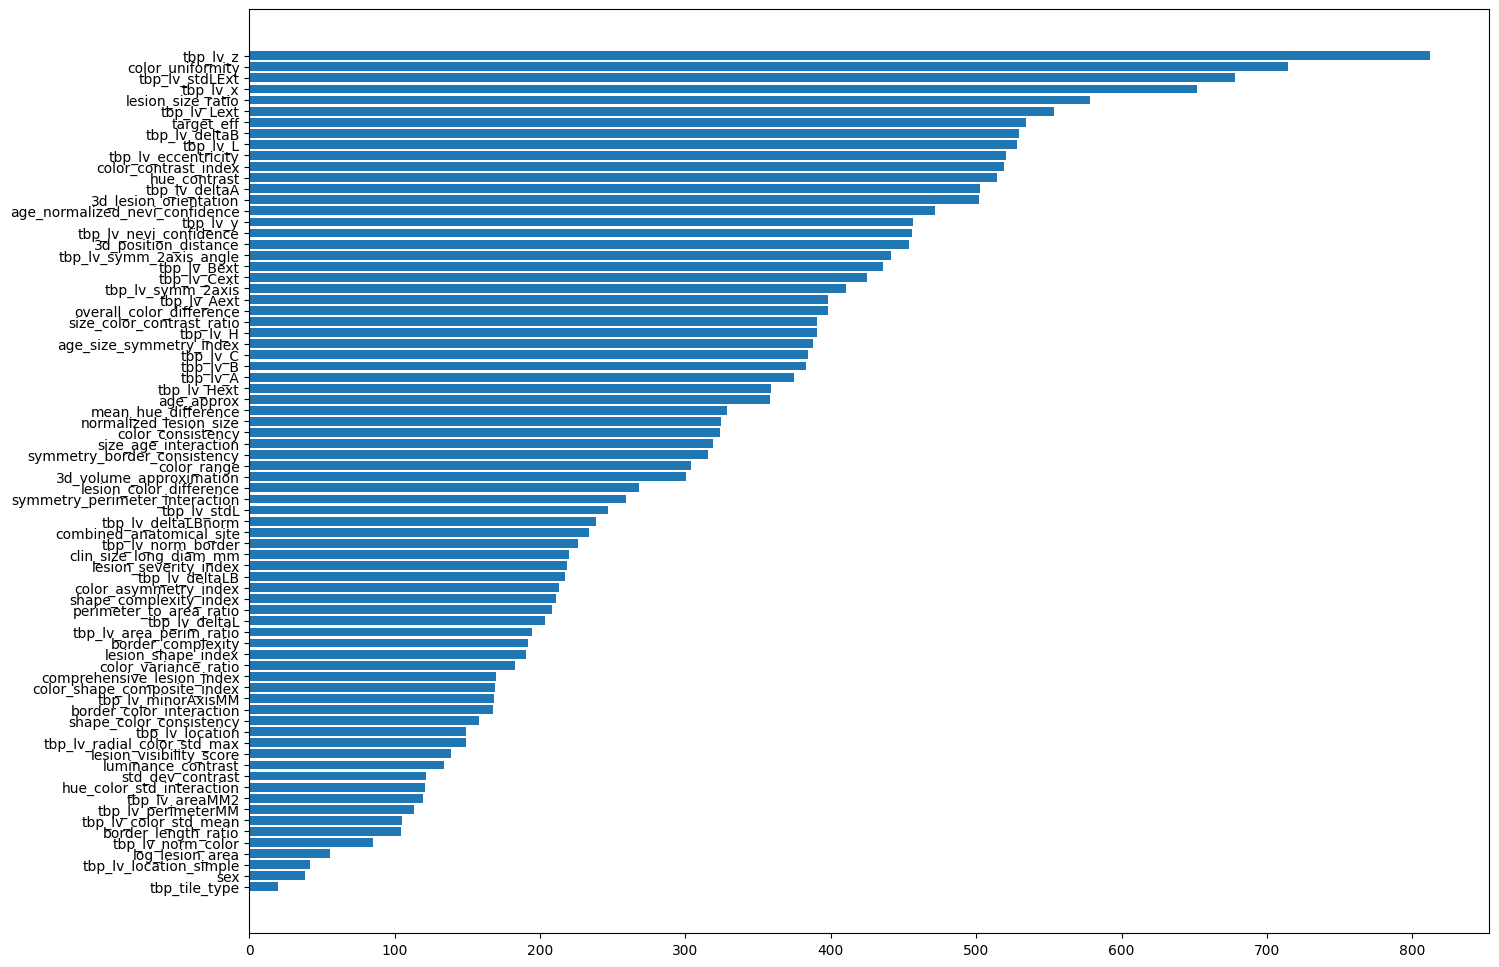

In [20]:
importances = np.mean([estimator.feature_importances_ for model in lgb_models for estimator in model.estimators_ ], 0)
df_imp = pd.DataFrame({"feature": lgb_models[0].estimators_[0].feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)
df_imp.to_csv("imp_lgbm.csv", index=False)

plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()